Best Start Time Offset found: 0.500 seconds
Minimum MSE Error: 2.831


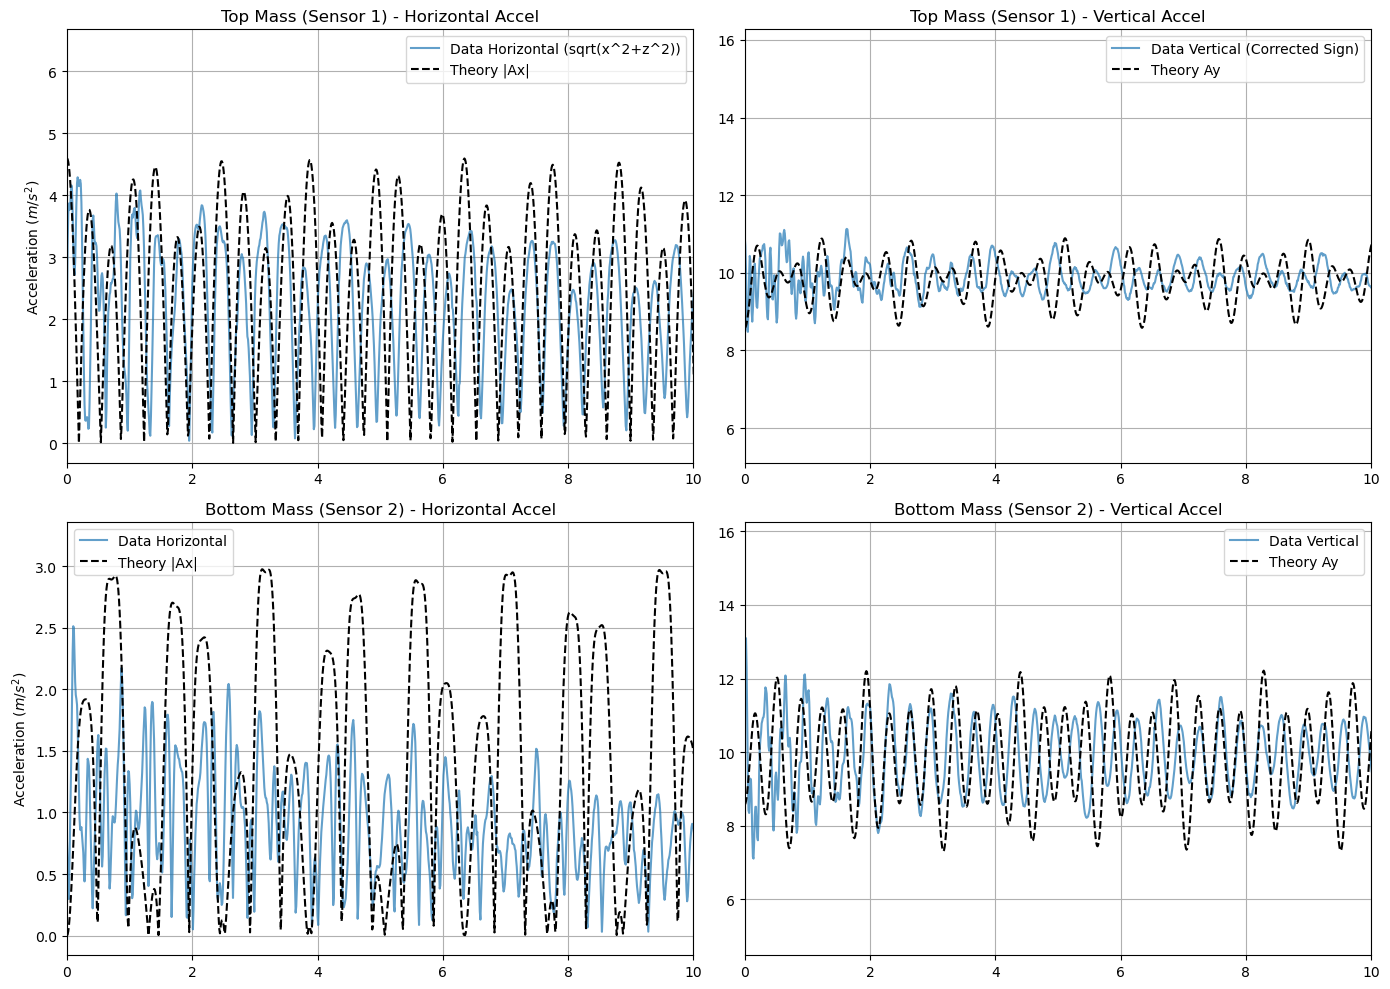

Found datasets to analyze: ['Ay (m/s²)', 'Ay (m/s²).1']

ANALYZING DATASET: Ay (m/s²)
Data centered by subtracting mean offset: 10.0478 m/s^2

--- Best-Fit Parameters (Simple Harmonic Model) ---
Acceleration Amplitude (A_accel): 0.0981 ± 0.0219 m/s^2
Position Amplitude (A_pos): 0.0015 m
Angular Frequency (omega): 8.0861 ± 0.0390 rad/s


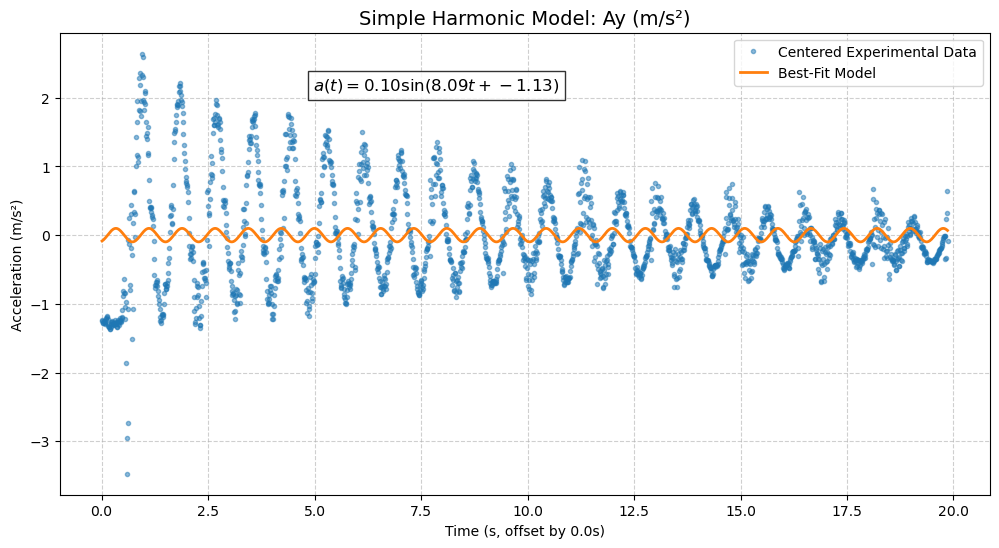

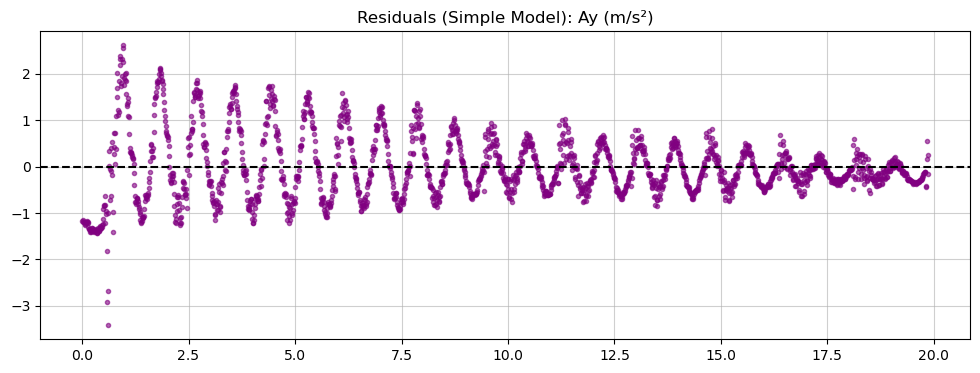


--- Linear Amplitude Decay Parameters ---
Decay Slope: -0.0409 (m/s^2)/s


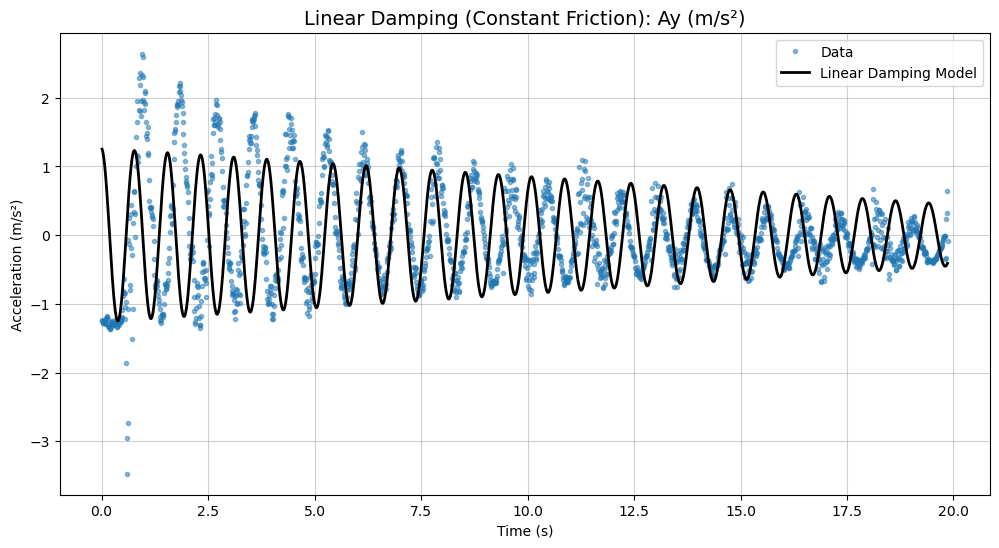


--- Best-Fit Parameters (Damped Model) ---
Damping Factor (beta): 0.0704 1/s
Damped Frequency (omega): 7.2625 rad/s


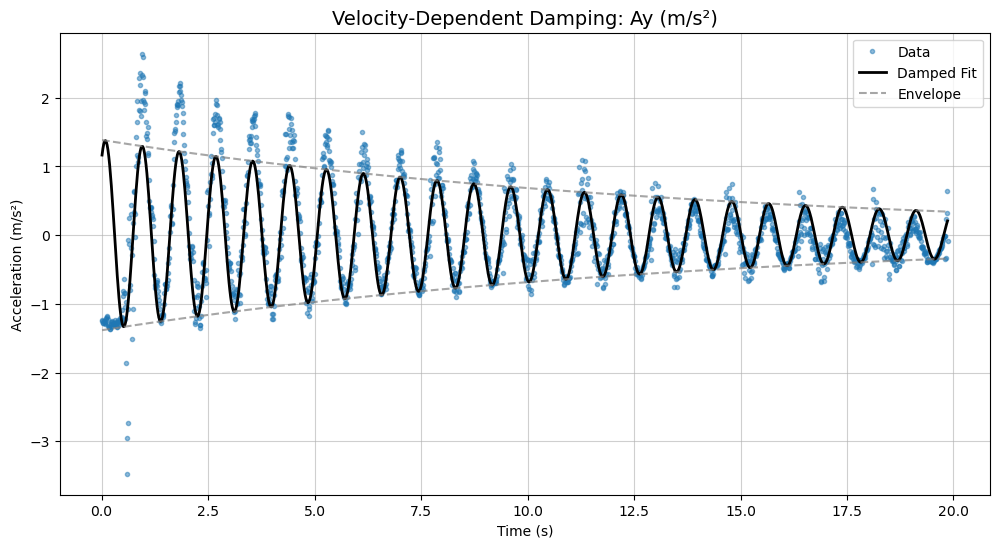

File '15degreesTopdisplaced30cm.csv' not found. Please ensure the CSV is in the same directory.

ANALYZING DATASET: Ay (m/s²).1
Data centered by subtracting mean offset: 9.7545 m/s^2

--- Best-Fit Parameters (Simple Harmonic Model) ---
Acceleration Amplitude (A_accel): 0.0285 ± 0.0110 m/s^2
Position Amplitude (A_pos): 0.0004 m
Angular Frequency (omega): 8.0915 ± 0.0670 rad/s


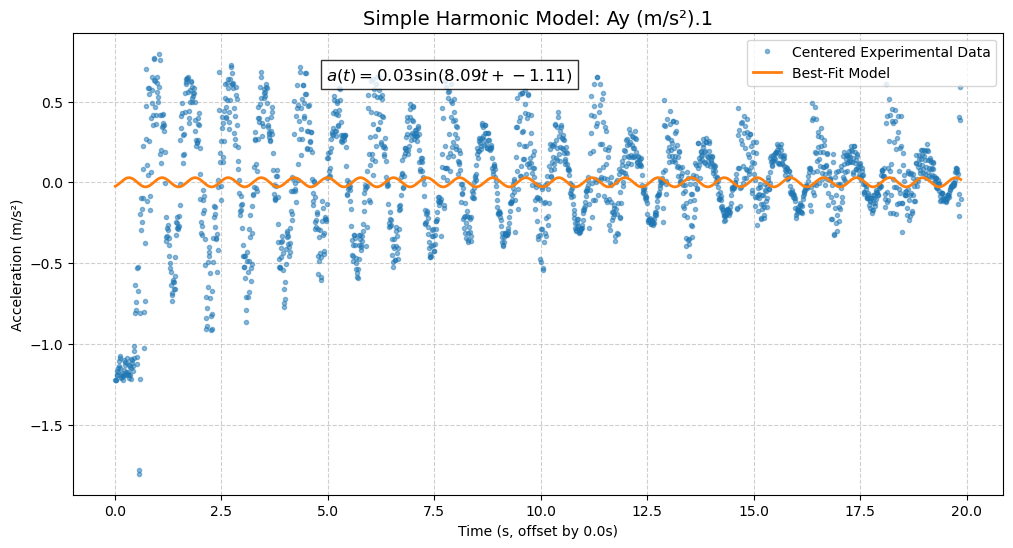

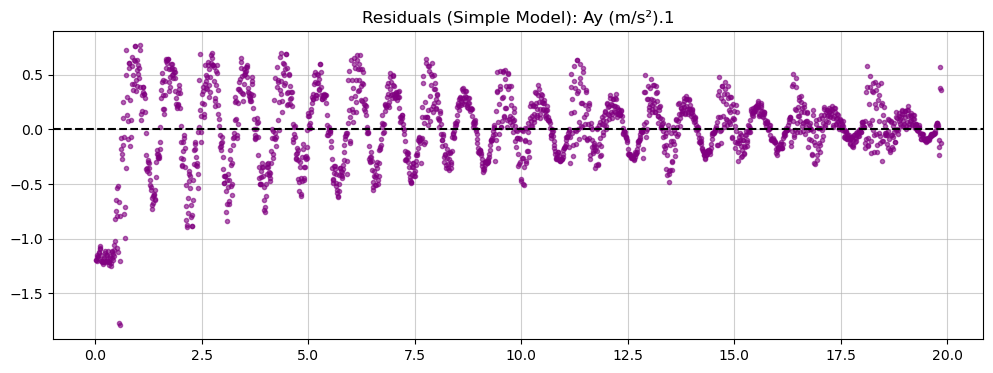


--- Linear Amplitude Decay Parameters ---
Decay Slope: -0.0179 (m/s^2)/s


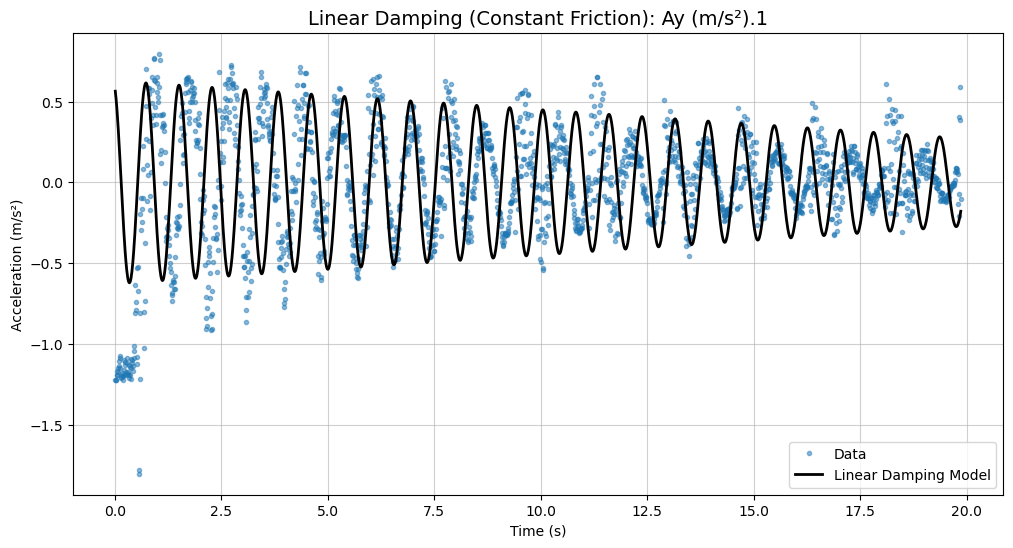


--- Best-Fit Parameters (Damped Model) ---
Damping Factor (beta): 0.0714 1/s
Damped Frequency (omega): 7.2241 rad/s


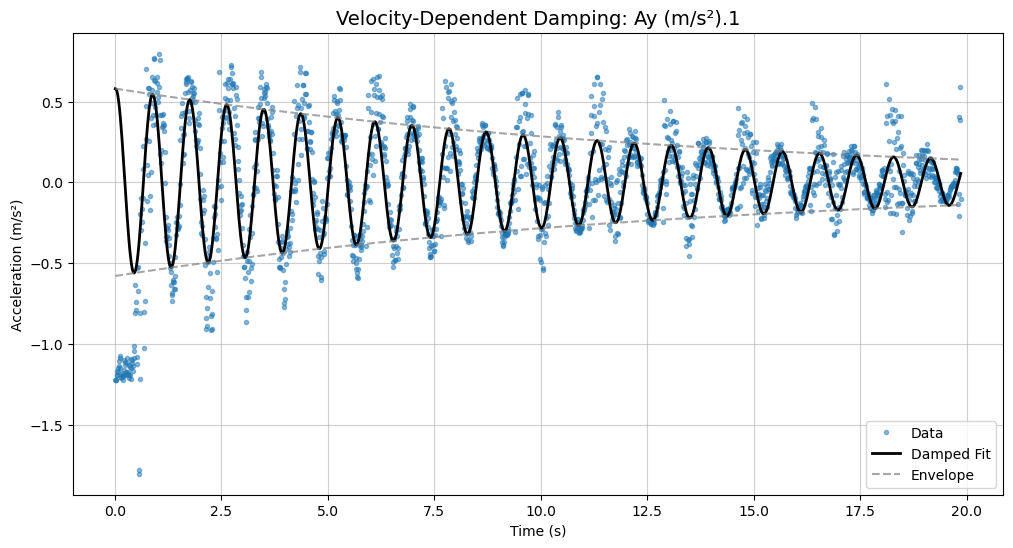

File '15degreesTopdisplaced30cm.csv' not found. Please ensure the CSV is in the same directory.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

def analyze_pendulum_fit(csv_file):
    # --- 1. Configuration & Constants ---
    L1, L2 = 0.365, 0.365  # Lengths in meters
    m1, m2 = 1.0, 1.0      # Masses (assumed equal, ratio matters most)
    g = 9.81               # Gravity
    
    # Initial Conditions (converted to radians)
    theta1_0 = np.radians(15)
    theta2_0 = np.radians(0)
    y0 = [theta1_0, 0.0, theta2_0, 0.0] # [theta1, omega1, theta2, omega2]

    # --- 2. Load and Preprocess Data ---
    # Read CSV (Handling duplicate column names automatically)
    df = pd.read_csv(csv_file)
    
    # Rename columns for clarity (Assuming order: Sensor 1, Sensor 2)
    # Adjust these indices if your columns are in a different order
    df.columns = ['Time', 'Ax1_raw', 'Ay1_raw', 'Az1_raw', 
                  'Ax2_raw', 'Ay2_raw', 'Az2_raw']
    
    # Filter data up to 15 seconds
    df = df[df['Time'] <= 15.0].copy()
    
    # Transform Acceleration
    # 1. "Cancel out spinning": Use magnitude of X and Z for horizontal component
    df['Ah1'] = np.sqrt(df['Ax1_raw']**2 + df['Az1_raw']**2)
    df['Ah2'] = np.sqrt(df['Ax2_raw']**2 + df['Az2_raw']**2)
    
    # 2. Correct Vertical Axes (Based on initial static readings)
    # Sensor 1 Ay starts negative (~-9.8), implying inverted axis relative to model
    df['Ay1'] = df['Ay1_raw'] * -1 
    # Sensor 2 Ay starts positive (~9.8), matches model
    df['Ay2'] = df['Ay2_raw'] * 1
    
    # --- 3. Theoretical Model ---
    def deriv(t, state, L1, L2, m1, m2, g):
        t1, w1, t2, w2 = state
        delta = t1 - t2
        den1 = (m1 + m2) * L1 - m2 * L1 * np.cos(delta)**2
        den2 = (L2/L1) * den1

        # Equation for theta1 double dot
        num1 = (m2 * L1 * w1**2 * np.sin(delta) * np.cos(delta) +
                m2 * g * np.sin(t2) * np.cos(delta) +
                m2 * L2 * w2**2 * np.sin(delta) -
                (m1 + m2) * g * np.sin(t1))
        a1 = num1 / den1

        # Equation for theta2 double dot
        num2 = (-m2 * L2 * w2**2 * np.sin(delta) * np.cos(delta) +
                (m1 + m2) * (g * np.sin(t1) * np.cos(delta) -
                             L1 * w1**2 * np.sin(delta) -
                             g * np.sin(t2)))
        a2 = num2 / den2
        
        return [w1, a1, w2, a2]

    # Solve ODE
    t_span = (0, 15.0)
    t_eval = np.linspace(0, 15.0, 1500)
    sol = solve_ivp(deriv, t_span, y0, args=(L1, L2, m1, m2, g), t_eval=t_eval, rtol=1e-9, atol=1e-9)

    # Compute Cartesian Accelerations from Angular Solutions
    # We need angular acceleration (alpha) to get cartesian acceleration
    # We re-evaluate the derivatives at each step
    alpha1 = []
    alpha2 = []
    for i in range(len(sol.t)):
        d = deriv(sol.t[i], sol.y[:, i], L1, L2, m1, m2, g)
        alpha1.append(d[1])
        alpha2.append(d[3])
    alpha1 = np.array(alpha1)
    alpha2 = np.array(alpha2)
    
    theta1, w1 = sol.y[0], sol.y[1]
    theta2, w2 = sol.y[2], sol.y[3]

    # Kinematic Acceleration (in lab frame, centered at pivot)
    # Mass 1
    ax1_k = L1 * (alpha1 * np.cos(theta1) - w1**2 * np.sin(theta1))
    ay1_k = L1 * (alpha1 * np.sin(theta1) + w1**2 * np.cos(theta1))
    
    # Mass 2 (Relative to Mass 1)
    ax2_k = ax1_k + L2 * (alpha2 * np.cos(theta2) - w2**2 * np.sin(theta2))
    ay2_k = ay1_k + L2 * (alpha2 * np.sin(theta2) + w2**2 * np.cos(theta2))

    # Sensor Acceleration (Kinematic + Gravity)
    # Sensors measure proper acceleration. Stationary sensor reads +g (upwards).
    # A_sensor = A_kinematic + g_vector_reaction
    # Assuming +y is Up, gravity acts Down. Reaction is Up (+g).
    theo_ax1 = ax1_k
    theo_ay1 = ay1_k + g
    theo_ax2 = ax2_k
    theo_ay2 = ay2_k + g

    # --- 4. Find Best Start Time (Fit Analysis) ---
    # We shift the data time to match the model (t_model = t_data - shift)
    shifts = np.linspace(0.0, 0.5, 100) # Search first 0.5 seconds
    errors = []
    
    # Interpolator for model (to compare at arbitrary shifts)
    f_ax1 = interp1d(sol.t, np.abs(theo_ax1), kind='cubic', fill_value="extrapolate")
    f_ay1 = interp1d(sol.t, theo_ay1, kind='cubic', fill_value="extrapolate")

    for s in shifts:
        # Shift data time
        t_shifted = df['Time'].values - s
        # Select valid overlap
        mask = (t_shifted >= 0) & (t_shifted <= 14.0)
        if np.sum(mask) == 0: 
            errors.append(np.inf)
            continue
            
        # Model predictions at these times
        pred_ax1 = f_ax1(t_shifted[mask])
        pred_ay1 = f_ay1(t_shifted[mask])
        
        # Data values
        real_ax1 = df.loc[mask, 'Ah1'].values
        real_ay1 = df.loc[mask, 'Ay1'].values
        
        # MSE Error
        err = np.mean((pred_ax1 - real_ax1)**2) + np.mean((pred_ay1 - real_ay1)**2)
        errors.append(err)

    best_shift = shifts[np.argmin(errors)]
    print(f"Best Start Time Offset found: {best_shift:.3f} seconds")
    print(f"Minimum MSE Error: {min(errors):.3f}")

    # --- 5. Plotting Results ---
    # Apply best shift for visualization
    df['Time_Aligned'] = df['Time'] - best_shift
    
    plt.figure(figsize=(14, 10))
    
    # Sensor 1 (Top)
    plt.subplot(2, 2, 1)
    plt.plot(df['Time_Aligned'], df['Ah1'], label='Data Horizontal (sqrt(x^2+z^2))', alpha=0.7)
    plt.plot(sol.t, np.abs(theo_ax1), 'k--', label='Theory |Ax|', linewidth=1.5)
    plt.xlim(0, 10)
    plt.title('Top Mass (Sensor 1) - Horizontal Accel')
    plt.ylabel('Acceleration ($m/s^2$)')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(df['Time_Aligned'], df['Ay1'], label='Data Vertical (Corrected Sign)', alpha=0.7)
    plt.plot(sol.t, theo_ay1, 'k--', label='Theory Ay', linewidth=1.5)
    plt.xlim(0, 10)
    plt.title('Top Mass (Sensor 1) - Vertical Accel')
    plt.legend()
    plt.grid(True)

    # Sensor 2 (Bottom)
    plt.subplot(2, 2, 3)
    plt.plot(df['Time_Aligned'], df['Ah2'], label='Data Horizontal', alpha=0.7)
    plt.plot(sol.t, np.abs(theo_ax2), 'k--', label='Theory |Ax|', linewidth=1.5)
    plt.xlim(0, 10)
    plt.title('Bottom Mass (Sensor 2) - Horizontal Accel')
    plt.ylabel('Acceleration ($m/s^2$)')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 4)
    plt.plot(df['Time_Aligned'], df['Ay2'], label='Data Vertical', alpha=0.7)
    plt.plot(sol.t, theo_ay2, 'k--', label='Theory Ay', linewidth=1.5)
    plt.xlim(0, 10)
    plt.title('Bottom Mass (Sensor 2) - Vertical Accel')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Execute
file_name = '15degreesTopdisplaced30cm.csv'
try:
    analyze_pendulum_fit(file_name)
except FileNotFoundError:import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.stats import linregress

# --- Configuration ---
filename = 'dowelInPhase.csv'
start_time = 0.0  # Adjusted for the new file
# We will look for columns containing 'Ay' to identify the two Y datasets
target_axis = 'Ay' 

# Load the dataframe
df = pd.read_csv(filename)
df.columns = df.columns.str.strip()

# Identify the time column and the two Y datasets
time_col = 'Time (s)'
y_datasets = [col for col in df.columns if target_axis in col]

print(f"Found datasets to analyze: {y_datasets}")

# --- Model Definitions ---

def sinusoidal_model(t, A, omega, phi):
    """Models a simple harmonic oscillator: a(t) = A * sin(omega*t + phi)."""
    return A * np.sin(omega * t + phi)

def damped_model_expanded(t, A_pos, beta, omega, phi):
    """Models a damped harmonic oscillator with velocity-dependent damping."""
    exp = np.exp(-beta * t)
    # derived acceleration equation for damped harmonic motion
    cos = (beta**2 - omega**2) * np.cos(omega * t + phi)
    sin = 2 * beta * omega * np.sin(omega * t + phi)
    return A_pos * exp * (cos + sin)

# --- Analysis Function ---

def analyze_dataset(df, time_col, data_col, start_time):
    print(f"\n{'='*40}")
    print(f"ANALYZING DATASET: {data_col}")
    print(f"{'='*40}")

    # 1. Prepare Data
    df_filtered = df[df[time_col] >= start_time].copy()
    time_data_offset = df_filtered[time_col].values - start_time
    
    # Center the data: Subtract the mean (gravity/tilt offset) to oscillate around 0
    raw_data = df_filtered[data_col].values
    data_offset_mean = np.mean(raw_data)
    acceleration_data_centered = raw_data - data_offset_mean
    print(f"Data centered by subtracting mean offset: {data_offset_mean:.4f} m/s^2")

    # 2. Simple Harmonic Model Fit
    initial_A = np.max(np.abs(acceleration_data_centered))
    initial_omega = 8.0 
    initial_phi = 0
    initial_guesses = [initial_A, initial_omega, initial_phi]

    try:
        popt, pcov = curve_fit(
            f=sinusoidal_model,
            xdata=time_data_offset,
            ydata=acceleration_data_centered,
            p0=initial_guesses
        )
        fit_A_accel, fit_omega, fit_phi = popt
        fit_A_accel_err, fit_omega_err, fit_phi_err = np.sqrt(np.diag(pcov))
        fit_A_pos = abs(fit_A_accel / (fit_omega**2))

        print("\n--- Best-Fit Parameters (Simple Harmonic Model) ---")
        print(f"Acceleration Amplitude (A_accel): {abs(fit_A_accel):.4f} ± {fit_A_accel_err:.4f} m/s^2")
        print(f"Position Amplitude (A_pos): {fit_A_pos:.4f} m")
        print(f"Angular Frequency (omega): {fit_omega:.4f} ± {fit_omega_err:.4f} rad/s")

        # Plot Simple Fit
        plt.figure(figsize=(12, 6))
        plt.plot(time_data_offset, acceleration_data_centered, 'o', markersize=3, label='Centered Experimental Data', alpha=0.5)
        time_plot = np.linspace(time_data_offset.min(), time_data_offset.max(), 1000)
        plt.plot(time_plot, sinusoidal_model(time_plot, *popt), '-', linewidth=2, label='Best-Fit Model')
        
        eq_string = (r'$a(t) = {:.2f} \sin({:.2f}t + {:.2f})$').format(fit_A_accel, fit_omega, fit_phi)
        plt.title(f'Simple Harmonic Model: {data_col}', fontsize=14)
        plt.xlabel(f'Time (s, offset by {start_time}s)')
        plt.ylabel('Acceleration (m/s²)')
        plt.legend(loc='upper right')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.text(time_data_offset.mean()*0.5, np.max(acceleration_data_centered)*0.8, eq_string, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
        plt.show()

        # Residuals Simple
        residuals = acceleration_data_centered - sinusoidal_model(time_data_offset, *popt)
        plt.figure(figsize=(12, 4))
        plt.plot(time_data_offset, residuals, 'o', markersize=3, color='purple', alpha=0.6)
        plt.axhline(0, color='black', linestyle='--')
        plt.title(f'Residuals (Simple Model): {data_col}')
        plt.grid(True, alpha=0.6)
        plt.show()

    except Exception as e:
        print(f"Simple fit failed for {data_col}: {e}")
        return # Stop analysis for this column if simple fit fails

    # 3. Linear Damping (Peak Decay)
    # Adjusted height threshold to be relative to the signal amplitude (10%)
    peak_indices, _ = find_peaks(acceleration_data_centered, height=initial_A*0.1, distance=15)
    
    if len(peak_indices) > 3:
        peak_times = time_data_offset[peak_indices]
        peak_amplitudes = acceleration_data_centered[peak_indices]

        lin_fit = linregress(peak_times, peak_amplitudes)
        print("\n--- Linear Amplitude Decay Parameters ---")
        print(f"Decay Slope: {lin_fit.slope:.4f} (m/s^2)/s")

        amplitude_over_time = lin_fit.intercept + lin_fit.slope * time_data_offset
        friction_model = amplitude_over_time * np.cos(fit_omega * (time_data_offset - peak_times[0]))

        plt.figure(figsize=(12, 6))
        plt.plot(time_data_offset, acceleration_data_centered, 'o', markersize=3, label='Data', alpha=0.5)
        plt.plot(time_data_offset, friction_model, '-', color='black', linewidth=2, label='Linear Damping Model')
        plt.title(f'Linear Damping (Constant Friction): {data_col}', fontsize=14)
        plt.xlabel('Time (s)')
        plt.ylabel('Acceleration (m/s²)')
        plt.grid(True, alpha=0.6)
        plt.legend()
        plt.show()
    else:
        print("\n[!] Not enough peaks found for linear decay analysis.")

    # 4. Velocity-Dependent Damped Model
    initial_guesses_damped = [fit_A_pos, 0.1, fit_omega, 0]
    
    try:
        popt_damped, pcov_damped = curve_fit(
            f=damped_model_expanded,
            xdata=time_data_offset,
            ydata=acceleration_data_centered,
            p0=initial_guesses_damped,
            maxfev=5000
        )
        fit_A_pos_damped, fit_beta, fit_omega_damped, fit_phi_damped = popt_damped
        max_accel_amp = abs(fit_A_pos_damped * (fit_beta**2 + fit_omega_damped**2))

        print("\n--- Best-Fit Parameters (Damped Model) ---")
        print(f"Damping Factor (beta): {fit_beta:.4f} 1/s")
        print(f"Damped Frequency (omega): {fit_omega_damped:.4f} rad/s")

        plt.figure(figsize=(12, 6))
        plt.plot(time_data_offset, acceleration_data_centered, 'o', markersize=3, label='Data', alpha=0.5)
        plt.plot(time_plot, damped_model_expanded(time_plot, *popt_damped), '-', color='black', linewidth=2, label='Damped Fit')
        
        envelope = max_accel_amp * np.exp(-fit_beta * time_plot)
        plt.plot(time_plot, envelope, '--', color='gray', alpha=0.7, label='Envelope')
        plt.plot(time_plot, -envelope, '--', color='gray', alpha=0.7)

        plt.title(f'Velocity-Dependent Damping: {data_col}', fontsize=14)
        plt.xlabel('Time (s)')
        plt.ylabel('Acceleration (m/s²)')
        plt.grid(True, alpha=0.6)
        plt.legend()
        plt.show()

    except Exception as e:
        print(f"Damped fit failed for {data_col}: {e}")

# --- Main Execution Loop ---
for col in y_datasets:
    analyze_dataset(df, time_col, col, start_time)
    print(f"File '{file_name}' not found. Please ensure the CSV is in the same directory.")

Optimization Complete.
Best Time Shift: 0.2442 s
Minimum Error: 2.5774


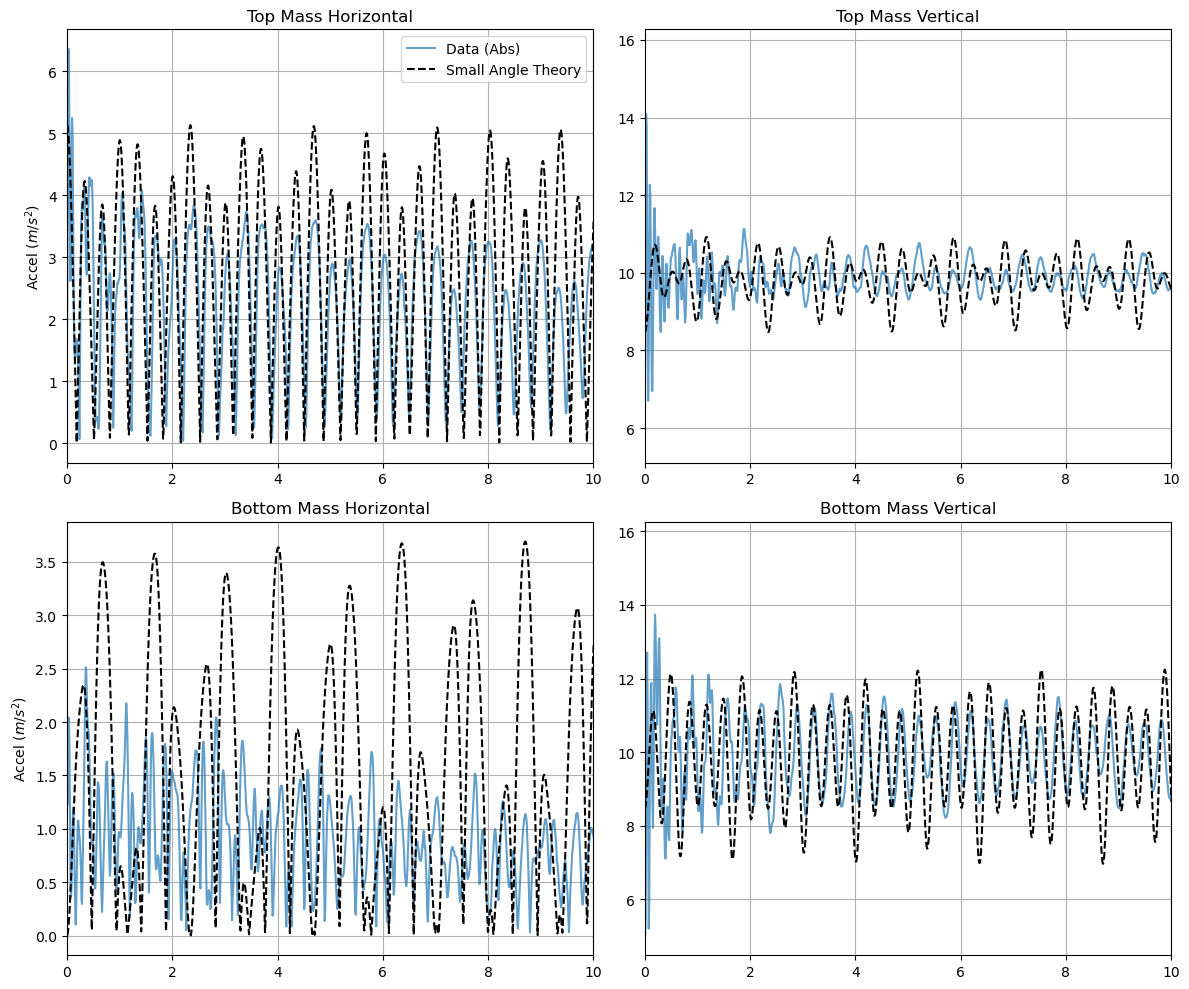

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.optimize import minimize

def analyze_small_angle_fit(csv_file):
    # --- 1. Configuration & Constants ---
    L1, L2 = 0.365, 0.365
    m1, m2 = 1.0, 1.0
    g = 9.81
    
    # Initial Conditions (15 degrees, 0 degrees)
    y0 = [np.radians(15), 0, np.radians(0), 0]

    # --- 2. Small Angle Approximation Model ---
    def deriv_small_angle(t, state, L1, L2, m1, m2, g):
        t1, w1, t2, w2 = state
        
        # Substitutions applied:
        # sin(x) -> x
        # cos(x) -> 1
        # sin(t1 - t2) -> (t1 - t2)
        # cos(t1 - t2) -> 1
        
        delta = t1 - t2
        
        # Denominator 1
        # Original: (m1 + m2)*L1 - m2*L1*cos(delta)**2
        # Approx:   (m1 + m2)*L1 - m2*L1*1
        den1 = m1 * L1
        
        # Denominator 2
        # Original: (L2/L1) * den1
        den2 = m1 * L2
        
        # Numerator 1
        # Original: m2*L1*w1^2*sin(delta)*cos(delta) + m2*g*sin(t2)*cos(delta) + ...
        # Approx:   m2*L1*w1^2*(delta)*1 + m2*g*(t2)*1 + ...
        num1 = (m2 * L1 * w1**2 * delta * 1 +
                m2 * g * t2 * 1 +
                m2 * L2 * w2**2 * delta -
                (m1 + m2) * g * t1)
        
        a1 = num1 / den1
        
        # Numerator 2
        num2 = (-m2 * L2 * w2**2 * delta * 1 +
                (m1 + m2) * (g * t1 * 1 -
                             L1 * w1**2 * delta -
                             g * t2))
        
        a2 = num2 / den2
        
        return [w1, a1, w2, a2]

    # Solve ODE
    t_span = (0, 16.0)
    sol = solve_ivp(deriv_small_angle, t_span, y0, args=(L1, L2, m1, m2, g), 
                    t_eval=np.linspace(0, 16, 2000), rtol=1e-9, atol=1e-9)

    # --- 3. Calculate Approximate Accelerations ---
    # We calculate alpha (angular accel) again using the small angle derivs
    alpha1, alpha2 = [], []
    for i in range(len(sol.t)):
        d = deriv_small_angle(sol.t[i], sol.y[:, i], L1, L2, m1, m2, g)
        alpha1.append(d[1])
        alpha2.append(d[3])
    alpha1, alpha2 = np.array(alpha1), np.array(alpha2)
    
    theta1, w1 = sol.y[0], sol.y[1]
    theta2, w2 = sol.y[2], sol.y[3]

    # Kinematics with Small Angle Substitutions
    # Ax = L * (alpha * cos(t) - w^2 * sin(t))  -> L * (alpha * 1 - w^2 * t)
    # Ay = L * (alpha * sin(t) + w^2 * cos(t))  -> L * (alpha * t + w^2 * 1)
    
    ax1_k = L1 * (alpha1 * 1 - w1**2 * theta1)
    ay1_k = L1 * (alpha1 * theta1 + w1**2 * 1)
    
    ax2_k = ax1_k + L2 * (alpha2 * 1 - w2**2 * theta2)
    ay2_k = ay1_k + L2 * (alpha2 * theta2 + w2**2 * 1)
    
    # Add Gravity (Sensor frame)
    theo_ax1 = ax1_k
    theo_ay1 = ay1_k + g
    theo_ax2 = ax2_k
    theo_ay2 = ay2_k + g

    # --- 4. Load and Preprocess Data ---
    df = pd.read_csv(csv_file)
    df.columns = ['Time', 'Ax1_raw', 'Ay1_raw', 'Az1_raw', 'Ax2_raw', 'Ay2_raw', 'Az2_raw']
    df = df[df['Time'] <= 15.0].copy()
    
    # Cancel spinning (Magnitude of horizontal) & Correct Signs
    df['Ah1'] = np.sqrt(df['Ax1_raw']**2 + df['Az1_raw']**2)
    df['Ah2'] = np.sqrt(df['Ax2_raw']**2 + df['Az2_raw']**2)
    df['Ay1'] = df['Ay1_raw'] * -1 
    df['Ay2'] = df['Ay2_raw'] * 1

    # --- 5. Optimize Time Shift ---
    # Create interpolation functions for theory
    f_ax1 = interp1d(sol.t, np.abs(theo_ax1), kind='cubic', fill_value="extrapolate")
    f_ay1 = interp1d(sol.t, theo_ay1, kind='cubic', fill_value="extrapolate")
    
    # Error function to minimize
    def get_fit_error(shift_val):
        t_shifted = df['Time'].values - shift_val
        # Compare only valid overlap region (e.g., 0 to 14s)
        mask = (t_shifted >= 0) & (t_shifted <= 14.0)
        if np.sum(mask) < 10: return 1e6
        
        # Predict
        pred_ax1 = f_ax1(t_shifted[mask])
        pred_ay1 = f_ay1(t_shifted[mask])
        
        # Data
        real_ax1 = df.loc[mask, 'Ah1'].values
        real_ay1 = df.loc[mask, 'Ay1'].values
        
        # MSE (Mean Squared Error)
        err = np.mean((pred_ax1 - real_ax1)**2) + np.mean((pred_ay1 - real_ay1)**2)
        return err

    # Search for best shift between 0.0 and 1.0 seconds
    res = minimize(get_fit_error, x0=[0.25], bounds=[(0.0, 1.0)], method='L-BFGS-B')
    best_shift = res.x[0]
    print(f"Optimization Complete.")
    print(f"Best Time Shift: {best_shift:.4f} s")
    print(f"Minimum Error: {res.fun:.4f}")

    # --- 6. Plotting ---
    df['Time_Aligned'] = df['Time'] - best_shift
    
    plt.figure(figsize=(12, 10))
    
    # Top Mass
    plt.subplot(2, 2, 1)
    plt.plot(df['Time_Aligned'], df['Ah1'], label='Data (Abs)', alpha=0.7)
    plt.plot(sol.t, np.abs(theo_ax1), 'k--', label='Small Angle Theory', linewidth=1.5)
    plt.xlim(0, 10)
    plt.title('Top Mass Horizontal')
    plt.ylabel('Accel ($m/s^2$)')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 2, 2)
    plt.plot(df['Time_Aligned'], df['Ay1'], label='Data (Corrected)', alpha=0.7)
    plt.plot(sol.t, theo_ay1, 'k--', label='Small Angle Theory', linewidth=1.5)
    plt.xlim(0, 10)
    plt.title('Top Mass Vertical')
    plt.grid(True)
    
    # Bottom Mass
    plt.subplot(2, 2, 3)
    plt.plot(df['Time_Aligned'], df['Ah2'], label='Data (Abs)', alpha=0.7)
    plt.plot(sol.t, np.abs(theo_ax2), 'k--', label='Small Angle Theory', linewidth=1.5)
    plt.xlim(0, 10)
    plt.title('Bottom Mass Horizontal')
    plt.ylabel('Accel ($m/s^2$)')
    plt.grid(True)
    
    plt.subplot(2, 2, 4)
    plt.plot(df['Time_Aligned'], df['Ay2'], label='Data', alpha=0.7)
    plt.plot(sol.t, theo_ay2, 'k--', label='Small Angle Theory', linewidth=1.5)
    plt.xlim(0, 10)
    plt.title('Bottom Mass Vertical')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

try:
    analyze_small_angle_fit('15degreesTopdisplaced30cm.csv')
except FileNotFoundError:
    print("File not found.")

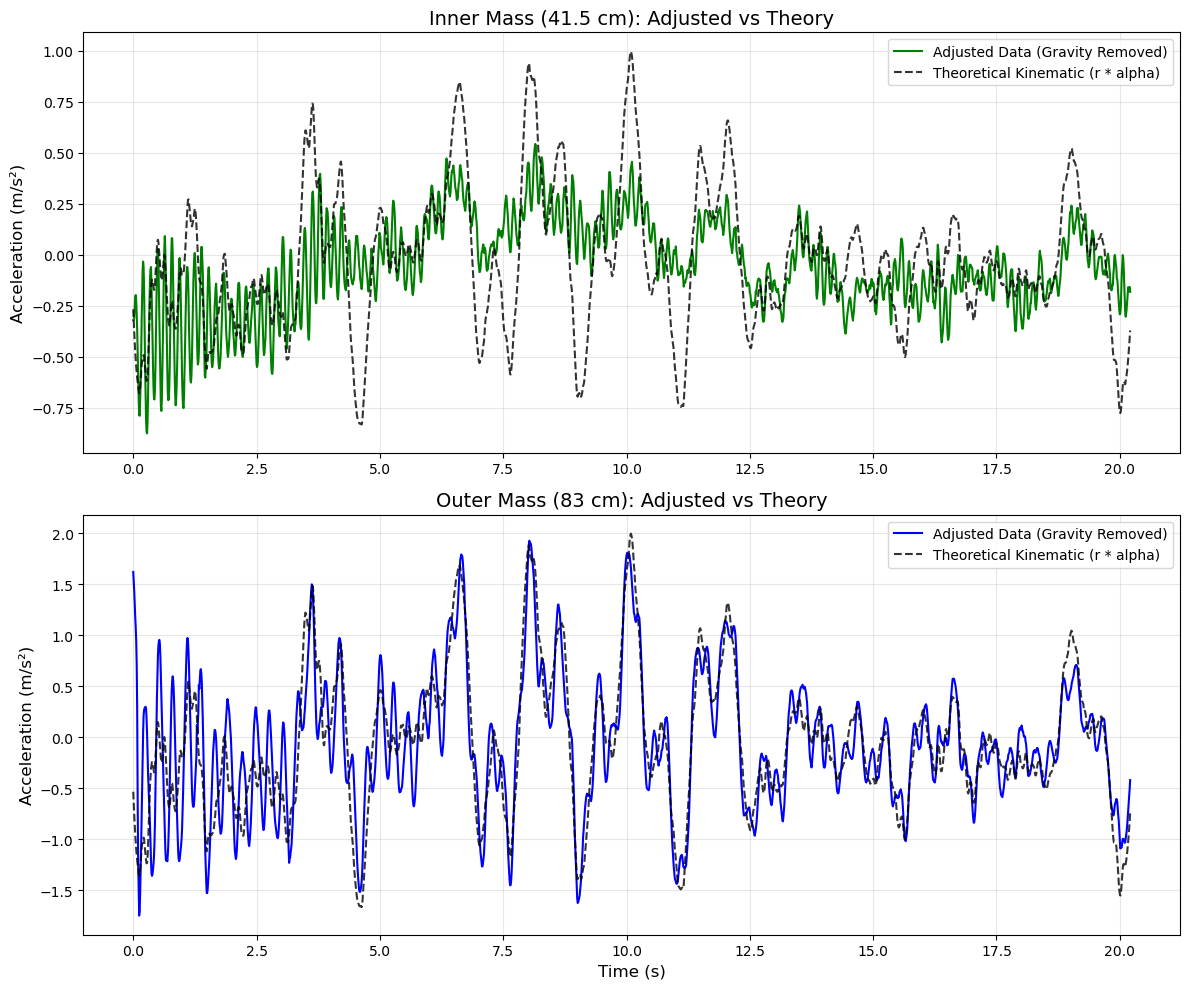

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

# 1. Load and Prepare Data
df = pd.read_csv('inphasetest.csv')
mask = df['Time (s)'] > 0.96
df_osc = df[mask].reset_index(drop=True)
t_rel = df_osc['Time (s)'].values - df_osc['Time (s)'].values[0]
dt = np.mean(np.diff(df_osc['Time (s)'].values))

# 2. Smooth Angular Velocity & Calculate Alpha
# Using 'ωy' (Set 1) as it had the strongest signal-to-noise ratio
wy = df_osc['ωy (rad/s)'].values
wy_centered = wy - np.mean(wy)
# Savitzky-Golay filter: Smooths and differentiates in one step
alpha_smooth = savgol_filter(wy_centered, window_length=21, polyorder=3, deriv=1, delta=dt)

# 3. Identify & Normalize Linear Data
# Set 1 (Inner, High Amp) -> Ax (Need to invert sign to match alpha convention)
raw_inner = -1 * (df_osc['Ax (m/s²)'].values - np.mean(df_osc['Ax (m/s²)'].values))
# Set 2 (Outer, Low Amp) -> Ax.1 (Signal is weak, but we use it)
raw_outer = df_osc['Ax (m/s²).1'].values - np.mean(df_osc['Ax (m/s²).1'].values)

# 4. Apply Physics Adjustment (Remove Gravity)
# Parameters
r_inner, r_outer = 0.415, 0.83
L_gyr = (r_inner**2 + r_outer**2) / (r_inner + r_outer) # ~0.69 m

# Adjustment: a_kin = a_meas + L_gyr * alpha
# Note: We use the theoretical gravity correction L_gyr * alpha
adj_inner = raw_inner + L_gyr * alpha_smooth
adj_outer = raw_outer + L_gyr * alpha_smooth

# 5. Theoretical Kinematic Model (a = r * alpha)
# We use the smooth alpha to generate the "ideal" kinematic curves
theo_kin_inner = r_inner * alpha_smooth
theo_kin_outer = r_outer * alpha_smooth

# 6. Plot Results
plt.figure(figsize=(12, 10))

# Plot 1: Inner Mass
plt.subplot(2, 1, 1)
plt.plot(t_rel, adj_inner, label='Adjusted Data (Gravity Removed)', color='green', linewidth=1.5)
plt.plot(t_rel, theo_kin_inner, 'k--', label='Theoretical Kinematic (r * alpha)', linewidth=1.5, alpha=0.8)
plt.title(f'Inner Mass (41.5 cm): Adjusted vs Theory', fontsize=14)
plt.ylabel('Acceleration (m/s²)', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# Plot 2: Outer Mass
plt.subplot(2, 1, 2)
plt.plot(t_rel, adj_outer, label='Adjusted Data (Gravity Removed)', color='blue', linewidth=1.5)
plt.plot(t_rel, theo_kin_outer, 'k--', label='Theoretical Kinematic (r * alpha)', linewidth=1.5, alpha=0.8)
plt.title(f'Outer Mass (83 cm): Adjusted vs Theory', fontsize=14)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Acceleration (m/s²)', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

pd.set_option('display.max_columns', None)
df = pd.read_csv('inphasetest.csv')

# Inspect the dataframe
print(df.head())
print(df.info())

# Handle duplicate column names
cols = pd.Series(df.columns)
for dup in cols[cols.duplicated()].unique(): 
    cols[cols[cols == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]
df.columns = cols

print(df.columns)

   Time (s)  Ax (m/s²)  Ay (m/s²)  Az (m/s²)  ωx (rad/s)  ωy (rad/s)  \
0      0.01   1.005543  -9.526154   1.053418   -0.301080   -4.884466   
1      0.02   0.896288  -9.534190   0.918070   -0.296644   -4.806846   
2      0.03   0.754771  -9.604383   0.842289   -0.293022   -4.682048   
3      0.04   0.622457  -9.680956   0.809628   -0.287537   -4.569250   
4      0.05   0.537897  -9.731770   0.802464   -0.289151   -4.419403   

   ωz (rad/s)  Ax (m/s²).1  Ay (m/s²).1  Az (m/s²).1  ωx (rad/s).1  \
0    0.415239     1.951754     9.581072    -0.371785     -0.399828   
1    0.415239     1.956524     9.581072    -0.347910     -0.407598   
2    0.415239     1.951815     9.581072    -0.371478     -0.401056   
3    0.416230     1.956483     9.581072    -0.348114     -0.406780   
4    0.425783     1.923601     9.624096    -0.267571     -0.443931   

   ωy (rad/s).1  ωz (rad/s).1  
0      0.212724     -0.195239  
1      0.217164     -0.200789  
2      0.213426     -0.196117  
3      0.216696   

Found datasets to analyze: ['Ay (m/s²)', 'Ay (m/s²).1']

ANALYZING DATASET: Ay (m/s²)
Data centered by subtracting mean offset: 10.0607 m/s^2

--- Best-Fit Parameters (Simple Harmonic Model) ---
Acceleration Amplitude (A_accel): 0.1131 ± 0.0202 m/s^2
Position Amplitude (A_pos): 0.0017 m
Angular Frequency (omega): 8.1102 ± 0.0333 rad/s


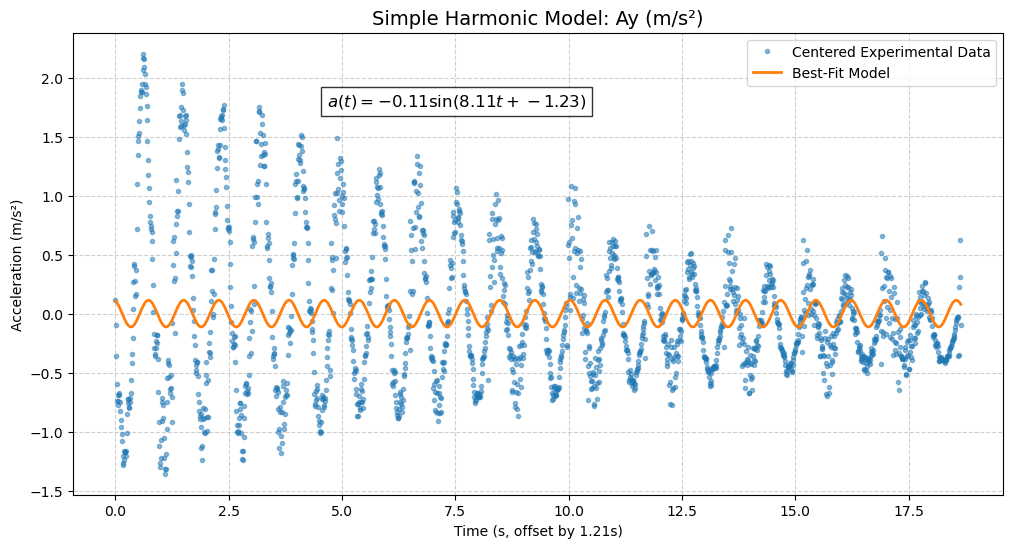

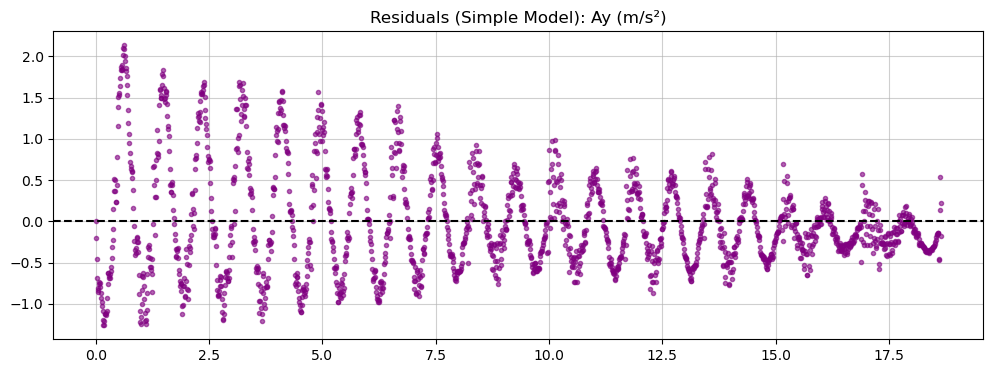


--- Linear Amplitude Decay Parameters ---
Decay Slope: -0.0460 (m/s^2)/s


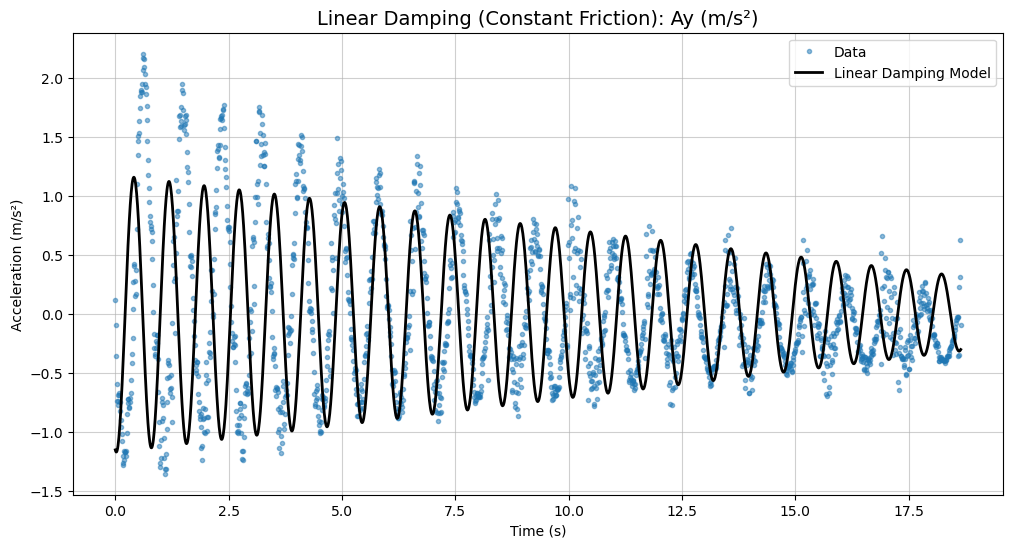


--- Best-Fit Parameters (Damped Model) ---
Damping Factor (beta): 0.0965 1/s
Damped Frequency (omega): 7.2819 rad/s


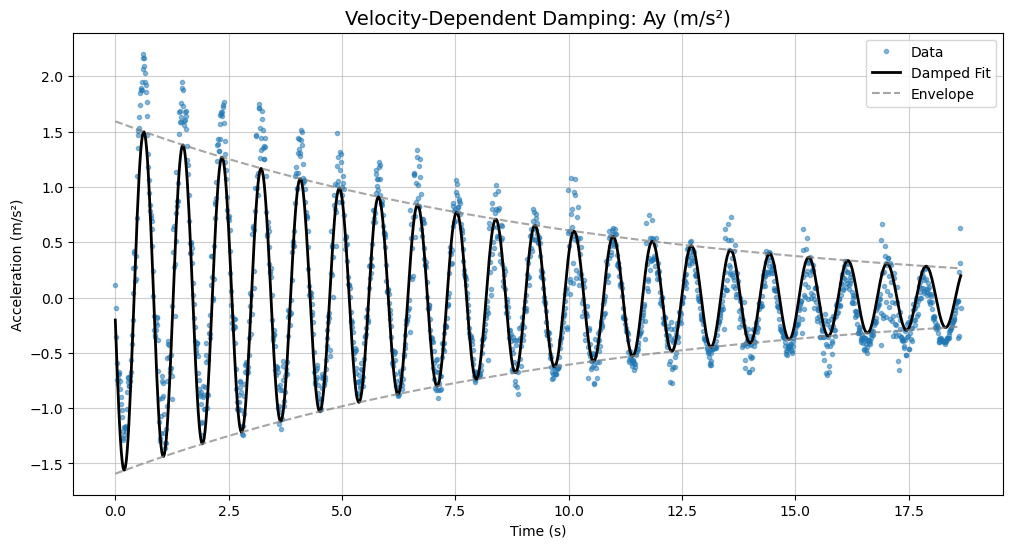


ANALYZING DATASET: Ay (m/s²).1
Data centered by subtracting mean offset: 9.7820 m/s^2

--- Best-Fit Parameters (Simple Harmonic Model) ---
Acceleration Amplitude (A_accel): 0.0424 ± 0.0091 m/s^2
Position Amplitude (A_pos): 0.0006 m
Angular Frequency (omega): 8.0910 ± 0.0400 rad/s


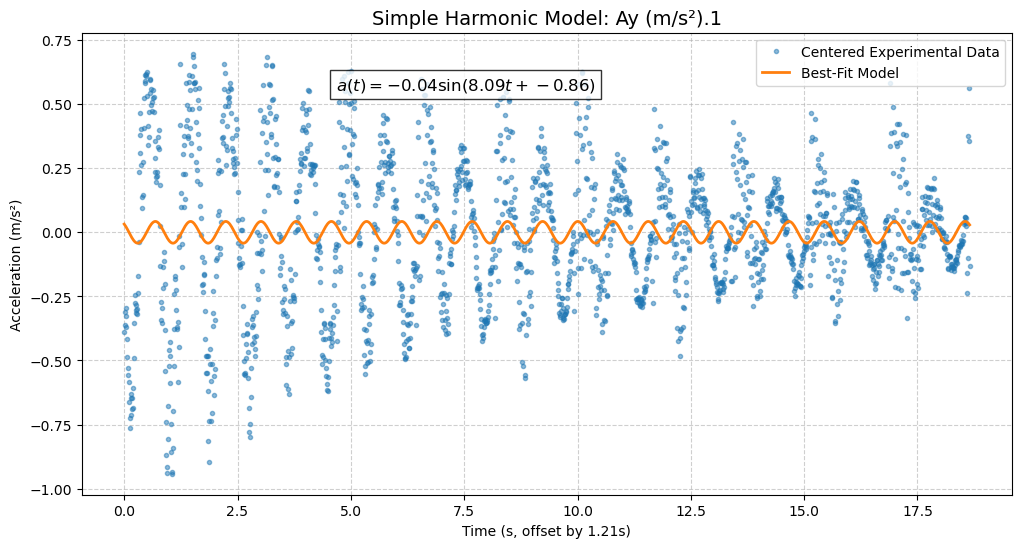

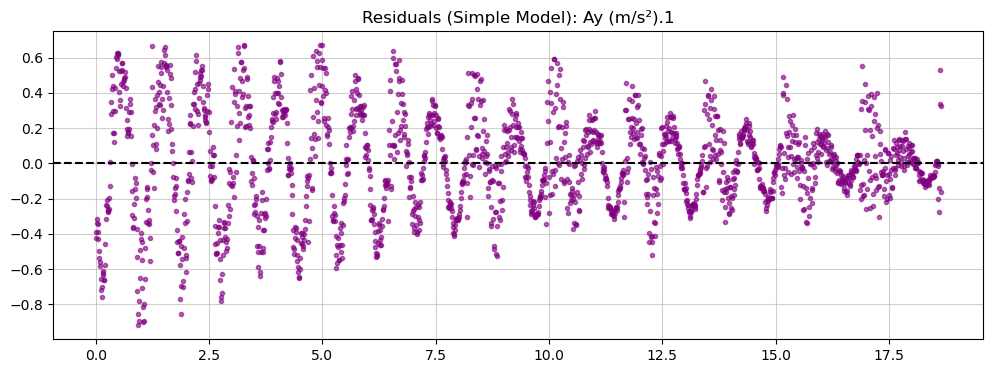


--- Linear Amplitude Decay Parameters ---
Decay Slope: -0.0183 (m/s^2)/s


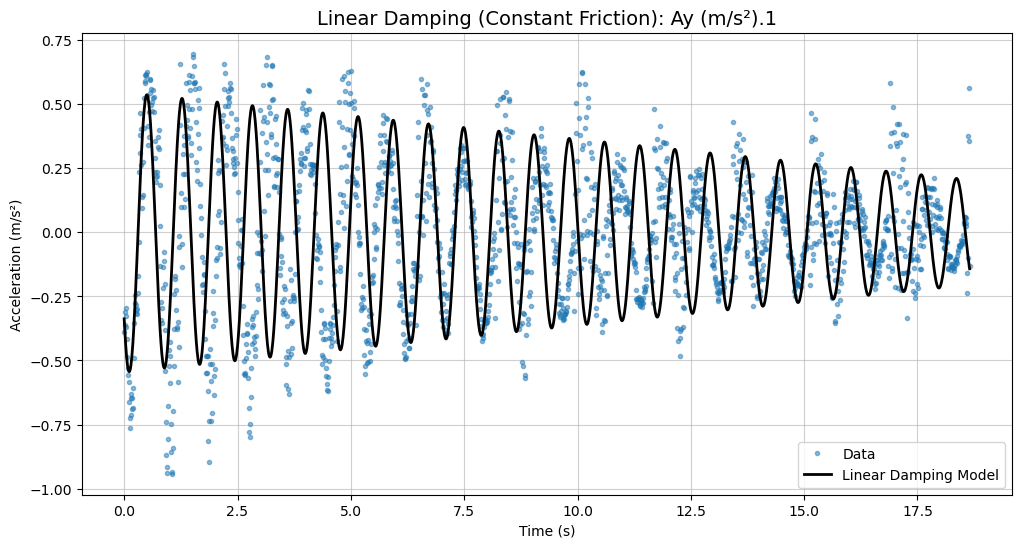


--- Best-Fit Parameters (Damped Model) ---
Damping Factor (beta): 0.0921 1/s
Damped Frequency (omega): 7.2606 rad/s


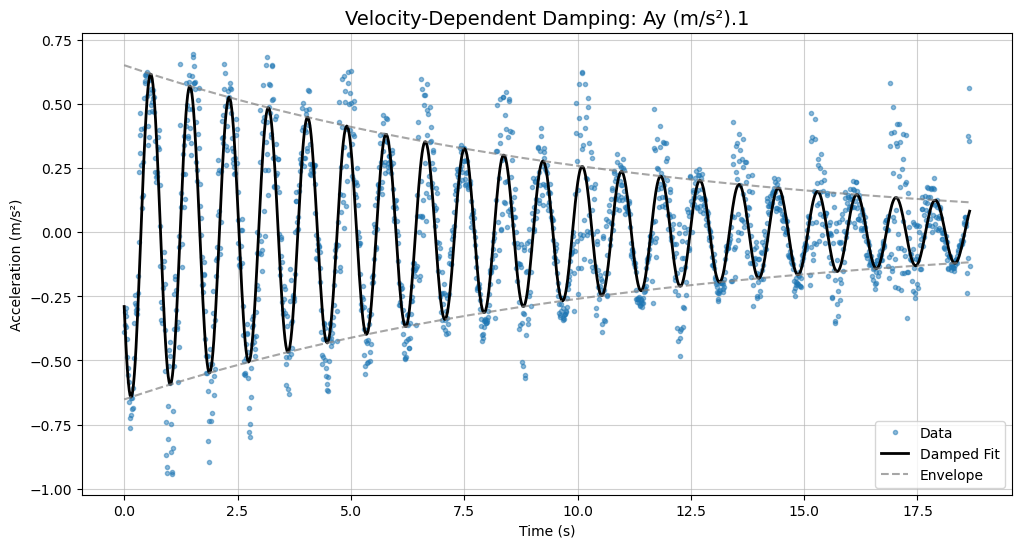

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.stats import linregress

# --- Configuration ---
filename = 'dowelInPhase.csv'
start_time = 1.21  # Adjusted for the new file
# We will look for columns containing 'Ay' to identify the two Y datasets
target_axis = 'Ay' 

# Load the dataframe
df = pd.read_csv(filename)
df.columns = df.columns.str.strip()

# Identify the time column and the two Y datasets
time_col = 'Time (s)'
y_datasets = [col for col in df.columns if target_axis in col]

print(f"Found datasets to analyze: {y_datasets}")

# --- Model Definitions ---

def sinusoidal_model(t, A, omega, phi):
    """Models a simple harmonic oscillator: a(t) = A * sin(omega*t + phi)."""
    return A * np.sin(omega * t + phi)

def damped_model_expanded(t, A_pos, beta, omega, phi):
    """Models a damped harmonic oscillator with velocity-dependent damping."""
    exp = np.exp(-beta * t)
    # derived acceleration equation for damped harmonic motion
    cos = (beta**2 - omega**2) * np.cos(omega * t + phi)
    sin = 2 * beta * omega * np.sin(omega * t + phi)
    return A_pos * exp * (cos + sin)

# --- Analysis Function ---

def analyze_dataset(df, time_col, data_col, start_time):
    print(f"\n{'='*40}")
    print(f"ANALYZING DATASET: {data_col}")
    print(f"{'='*40}")

    # 1. Prepare Data
    df_filtered = df[df[time_col] >= start_time].copy()
    time_data_offset = df_filtered[time_col].values - start_time
    
    # Center the data: Subtract the mean (gravity/tilt offset) to oscillate around 0
    raw_data = df_filtered[data_col].values
    data_offset_mean = np.mean(raw_data)
    acceleration_data_centered = raw_data - data_offset_mean
    print(f"Data centered by subtracting mean offset: {data_offset_mean:.4f} m/s^2")

    # 2. Simple Harmonic Model Fit
    initial_A = np.max(np.abs(acceleration_data_centered))
    initial_omega = 8.0 
    initial_phi = 0
    initial_guesses = [initial_A, initial_omega, initial_phi]

    try:
        popt, pcov = curve_fit(
            f=sinusoidal_model,
            xdata=time_data_offset,
            ydata=acceleration_data_centered,
            p0=initial_guesses
        )
        fit_A_accel, fit_omega, fit_phi = popt
        fit_A_accel_err, fit_omega_err, fit_phi_err = np.sqrt(np.diag(pcov))
        fit_A_pos = abs(fit_A_accel / (fit_omega**2))

        print("\n--- Best-Fit Parameters (Simple Harmonic Model) ---")
        print(f"Acceleration Amplitude (A_accel): {abs(fit_A_accel):.4f} ± {fit_A_accel_err:.4f} m/s^2")
        print(f"Position Amplitude (A_pos): {fit_A_pos:.4f} m")
        print(f"Angular Frequency (omega): {fit_omega:.4f} ± {fit_omega_err:.4f} rad/s")

        # Plot Simple Fit
        plt.figure(figsize=(12, 6))
        plt.plot(time_data_offset, acceleration_data_centered, 'o', markersize=3, label='Centered Experimental Data', alpha=0.5)
        time_plot = np.linspace(time_data_offset.min(), time_data_offset.max(), 1000)
        plt.plot(time_plot, sinusoidal_model(time_plot, *popt), '-', linewidth=2, label='Best-Fit Model')
        
        eq_string = (r'$a(t) = {:.2f} \sin({:.2f}t + {:.2f})$').format(fit_A_accel, fit_omega, fit_phi)
        plt.title(f'Simple Harmonic Model: {data_col}', fontsize=14)
        plt.xlabel(f'Time (s, offset by {start_time}s)')
        plt.ylabel('Acceleration (m/s²)')
        plt.legend(loc='upper right')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.text(time_data_offset.mean()*0.5, np.max(acceleration_data_centered)*0.8, eq_string, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
        plt.show()

        # Residuals Simple
        residuals = acceleration_data_centered - sinusoidal_model(time_data_offset, *popt)
        plt.figure(figsize=(12, 4))
        plt.plot(time_data_offset, residuals, 'o', markersize=3, color='purple', alpha=0.6)
        plt.axhline(0, color='black', linestyle='--')
        plt.title(f'Residuals (Simple Model): {data_col}')
        plt.grid(True, alpha=0.6)
        plt.show()

    except Exception as e:
        print(f"Simple fit failed for {data_col}: {e}")
        return # Stop analysis for this column if simple fit fails

    # 3. Linear Damping (Peak Decay)
    # Adjusted height threshold to be relative to the signal amplitude (10%)
    peak_indices, _ = find_peaks(acceleration_data_centered, height=initial_A*0.1, distance=15)
    
    if len(peak_indices) > 3:
        peak_times = time_data_offset[peak_indices]
        peak_amplitudes = acceleration_data_centered[peak_indices]

        lin_fit = linregress(peak_times, peak_amplitudes)
        print("\n--- Linear Amplitude Decay Parameters ---")
        print(f"Decay Slope: {lin_fit.slope:.4f} (m/s^2)/s")

        amplitude_over_time = lin_fit.intercept + lin_fit.slope * time_data_offset
        friction_model = amplitude_over_time * np.cos(fit_omega * (time_data_offset - peak_times[0]))

        plt.figure(figsize=(12, 6))
        plt.plot(time_data_offset, acceleration_data_centered, 'o', markersize=3, label='Data', alpha=0.5)
        plt.plot(time_data_offset, friction_model, '-', color='black', linewidth=2, label='Linear Damping Model')
        plt.title(f'Linear Damping (Constant Friction): {data_col}', fontsize=14)
        plt.xlabel('Time (s)')
        plt.ylabel('Acceleration (m/s²)')
        plt.grid(True, alpha=0.6)
        plt.legend()
        plt.show()
    else:
        print("\n[!] Not enough peaks found for linear decay analysis.")

    # 4. Velocity-Dependent Damped Model
    initial_guesses_damped = [fit_A_pos, 0.1, fit_omega, 0]
    
    try:
        popt_damped, pcov_damped = curve_fit(
            f=damped_model_expanded,
            xdata=time_data_offset,
            ydata=acceleration_data_centered,
            p0=initial_guesses_damped,
            maxfev=5000
        )
        fit_A_pos_damped, fit_beta, fit_omega_damped, fit_phi_damped = popt_damped
        max_accel_amp = abs(fit_A_pos_damped * (fit_beta**2 + fit_omega_damped**2))

        print("\n--- Best-Fit Parameters (Damped Model) ---")
        print(f"Damping Factor (beta): {fit_beta:.4f} 1/s")
        print(f"Damped Frequency (omega): {fit_omega_damped:.4f} rad/s")

        plt.figure(figsize=(12, 6))
        plt.plot(time_data_offset, acceleration_data_centered, 'o', markersize=3, label='Data', alpha=0.5)
        plt.plot(time_plot, damped_model_expanded(time_plot, *popt_damped), '-', color='black', linewidth=2, label='Damped Fit')
        
        envelope = max_accel_amp * np.exp(-fit_beta * time_plot)
        plt.plot(time_plot, envelope, '--', color='gray', alpha=0.7, label='Envelope')
        plt.plot(time_plot, -envelope, '--', color='gray', alpha=0.7)

        plt.title(f'Velocity-Dependent Damping: {data_col}', fontsize=14)
        plt.xlabel('Time (s)')
        plt.ylabel('Acceleration (m/s²)')
        plt.grid(True, alpha=0.6)
        plt.legend()
        plt.show()

    except Exception as e:
        print(f"Damped fit failed for {data_col}: {e}")

# --- Main Execution Loop ---
for col in y_datasets:
    analyze_dataset(df, time_col, col, start_time)

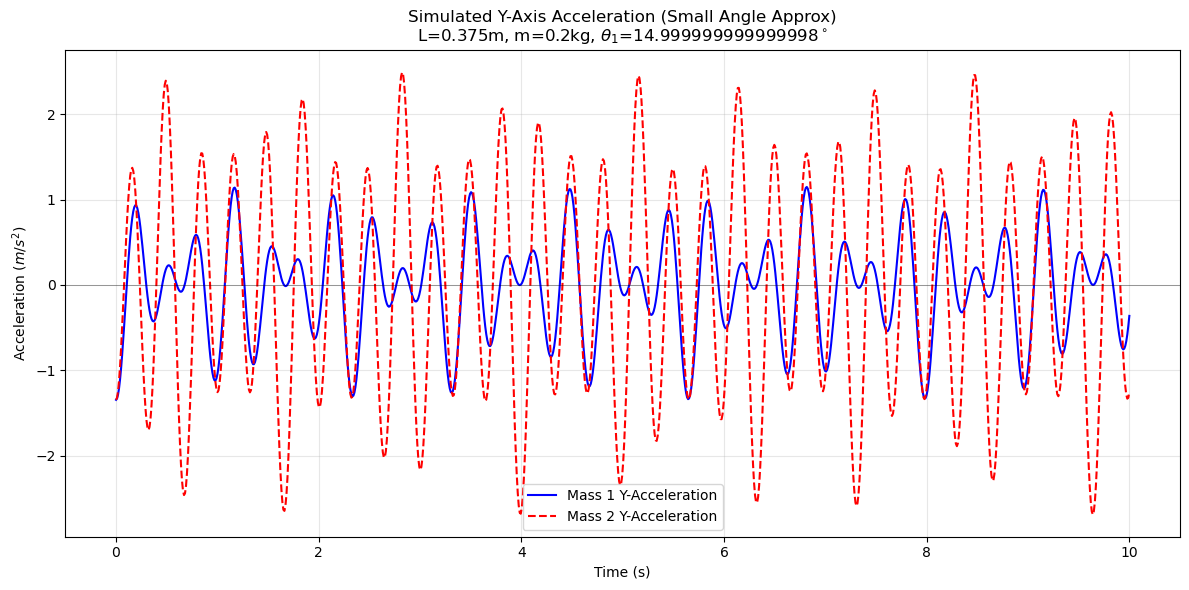

In [7]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# 1. Constants and Parameters
g = 9.81          # Gravity (m/s^2)
L = 0.375         # Length l1 = l2 (m)
m = 0.200         # Mass m1 = m2 (kg)

# Initial conditions (convert degrees to radians)
theta1_0 = np.radians(15)
theta2_0 = np.radians(0)
omega1_0 = 0.0    # Assume starting from rest
omega2_0 = 0.0    # Assume starting from rest

# 2. Linearized Equations of Motion
# Derived from Euler-Lagrange with small angle approx (sin(x)=x, cos(x)=1, terms > 2nd order ignored)
# For m1=m2=m and l1=l2=L:
#   2L*theta1'' + L*theta2'' + 2g*theta1 = 0
#   L*theta1'' + L*theta2'' + g*theta2 = 0
#
# Solving for accelerations (alpha):
#   alpha1 = (g/L) * (theta2 - 2*theta1)
#   alpha2 = (2*g/L) * (theta1 - theta2)

def deriv(state, t, g, L):
    theta1, omega1, theta2, omega2 = state
    
    # Calculate angular accelerations (alphas) using the linearized equations
    alpha1 = (g / L) * (theta2 - 2 * theta1)
    alpha2 = (2 * g / L) * (theta1 - theta2)
    
    return [omega1, alpha1, omega2, alpha2]

# 3. Solve the ODE
t = np.linspace(0, 10, 1000) # 10 seconds, 1000 steps
state0 = [theta1_0, omega1_0, theta2_0, omega2_0]

solution = odeint(deriv, state0, t, args=(g, L))

theta1 = solution[:, 0]
omega1 = solution[:, 1]
theta2 = solution[:, 2]
omega2 = solution[:, 3]

# 4. Compute Y-Axis Acceleration
# Exact geometric relation: y = -L cos(theta)
# Differentiating twice: y'' = L(alpha * sin(theta) + omega^2 * cos(theta))
# Small Angle Approximation for conversion: sin(theta) ~ theta, cos(theta) ~ 1
# y'' ~ L(theta * alpha + omega^2)

# Recalculate alphas for every time step to use in conversion
alpha1 = (g / L) * (theta2 - 2 * theta1)
alpha2 = (2 * g / L) * (theta1 - theta2)

# Acceleration of m1 (y1)
y_acc_1 = L * (theta1 * alpha1 + omega1**2)

# Acceleration of m2 (y2)
# y2 position is y1 + y_rel, so y2'' = y1'' + y_rel''
y_rel_acc = L * (theta2 * alpha2 + omega2**2)
y_acc_2 = y_acc_1 + y_rel_acc

# 5. Plotting
plt.figure(figsize=(12, 6))

plt.plot(t, y_acc_1, label='Mass 1 Y-Acceleration', color='blue', linewidth=1.5)
plt.plot(t, y_acc_2, label='Mass 2 Y-Acceleration', color='red', linestyle='--', linewidth=1.5)

plt.title(f'Simulated Y-Axis Acceleration (Small Angle Approx)\nL={L}m, m={m}kg, $\\theta_1$={np.degrees(theta1_0)}$^\\circ$')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration ($m/s^2$)')
plt.axhline(0, color='black', linewidth=0.5, alpha=0.5)
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

Optimizing time shift (searching 0.5s - 1.5s)...
Optimal Time Shift found: 1.0600 seconds


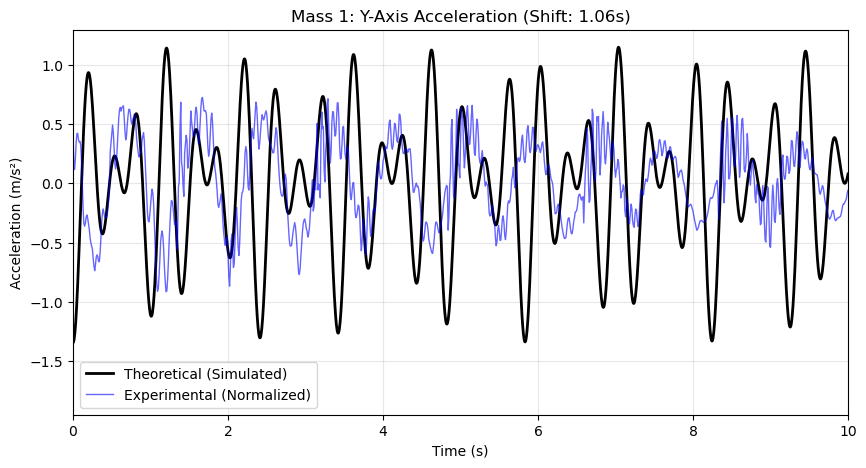

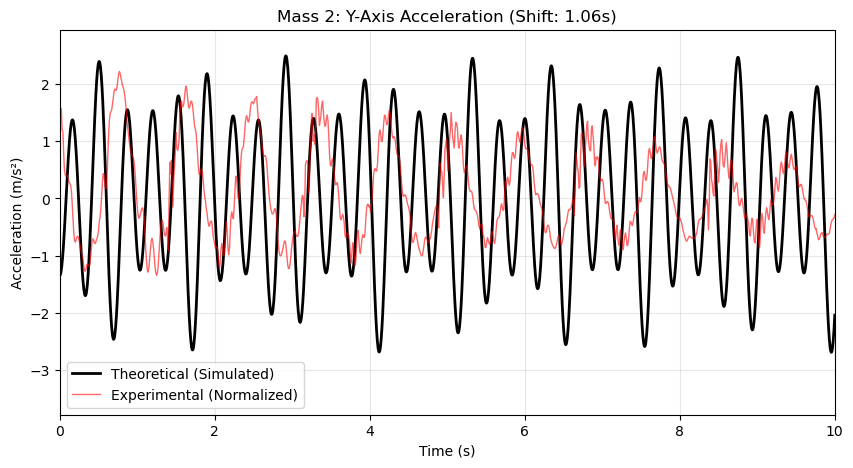

In [3]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar
import os

# ==========================================
# 1. THEORETICAL SIMULATION
# ==========================================
def run_simulation(duration=10, steps=2000):
    g = 9.81
    L = 0.40
    m = 0.200
    
    # Initial Conditions
    theta1_0 = np.radians(15)
    theta2_0 = np.radians(0)
    state0 = [theta1_0, 0, theta2_0, 0] # [th1, w1, th2, w2]
    
    t = np.linspace(0, duration, steps)
    
    def deriv(state, t, g, L):
        theta1, omega1, theta2, omega2 = state
        # Linearized equations for m1=m2, l1=l2
        alpha1 = (g / L) * (theta2 - 2 * theta1)
        alpha2 = (2 * g / L) * (theta1 - theta2)
        return [omega1, alpha1, omega2, alpha2]

    sol = odeint(deriv, state0, t, args=(g, L))
    
    theta1, omega1 = sol[:, 0], sol[:, 1]
    theta2, omega2 = sol[:, 2], sol[:, 3]
    
    # Calculate Theoretical Accelerations
    # Recalculate alphas
    alpha1 = (g / L) * (theta2 - 2 * theta1)
    alpha2 = (2 * g / L) * (theta1 - theta2)
    
    # y'' approx L(theta*alpha + omega^2)
    acc_y1_theory = L * (theta1 * alpha1 + omega1**2)
    
    # y2'' = y1'' + y_rel''
    acc_y_rel = L * (theta2 * alpha2 + omega2**2)
    acc_y2_theory = acc_y1_theory + acc_y_rel
    
    return t, acc_y1_theory, acc_y2_theory

# ==========================================
# 2. DATA PROCESSING & OPTIMIZATION
# ==========================================
def load_and_process_data(filename):
    try:
        # Load CSV
        df = pd.read_csv(filename)
        
        # Access by INDEX because columns have duplicate names (Ay, Ay)
        # Index 0: Time
        # Index 2: Ay (Sensor 1) -> Now mapped to Mass 2
        # Index 5: Ay (Sensor 2) -> Now mapped to Mass 1
        
        t_exp = df.iloc[:, 0].values
        # Swapped indices per user request
        acc1_exp = df.iloc[:, 5].values  # Mass 1 uses Sensor 2
        acc2_exp = df.iloc[:, 2].values  # Mass 2 uses Sensor 1
        
        # Normalize (Center around zero)
        acc1_exp = acc1_exp - np.mean(acc1_exp)
        acc2_exp = acc2_exp - np.mean(acc2_exp)
        
        return t_exp, acc1_exp, acc2_exp
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None, None

def find_best_shift(t_theory, y_theory, t_exp, y_exp, search_bounds=(0.5, 1.5)):
    """
    Finds time shift 'dt' such that y_exp(t - dt) aligns best with y_theory(t).
    Search bounds set to look around 1.0 second.
    """
    # Create interpolation function for theory
    theory_interp = interp1d(t_theory, y_theory, kind='cubic', fill_value="extrapolate")
    
    def error_func(dt):
        # Shift experimental time
        t_shifted = t_exp - dt
        
        # Filter to overlapping region only to avoid extrapolation errors
        mask = (t_shifted >= t_theory.min()) & (t_shifted <= t_theory.max())
        if np.sum(mask) < 10: return float('inf') # Safety check
        
        y_exp_segment = y_exp[mask]
        t_segment = t_shifted[mask]
        
        # Interpolate theory to matched shifted time points
        y_theory_interp = theory_interp(t_segment)
        
        # Calculate Mean Squared Error
        mse = np.mean((y_exp_segment - y_theory_interp)**2)
        return mse

    # Minimize error
    res = minimize_scalar(error_func, bounds=search_bounds, method='bounded')
    return res.x

# ==========================================
# 3. MAIN EXECUTION & PLOTTING
# ==========================================

# 1. Run Theory
t_theory, y1_theory, y2_theory = run_simulation(duration=10)

# 2. Load Experiment
filename = 'dowelInPhase.csv'
t_exp, y1_exp, y2_exp = load_and_process_data(filename)

if t_exp is not None:
    # 3. Optimize Shift (Using Mass 1 as the primary reference for sync)
    print("Optimizing time shift (searching 0.5s - 1.5s)...")
    best_shift = find_best_shift(t_theory, y1_theory, t_exp, y1_exp, search_bounds=(1.0, 1.1))
    print(f"Optimal Time Shift found: {best_shift:.4f} seconds")

    # Shift experimental time
    t_exp_shifted = t_exp - best_shift

    # 4. Plotting - SEPARATE GRAPHS
    
    # --- Graph 1: Mass 1 ---
    plt.figure(figsize=(10, 5))
    plt.plot(t_theory, y1_theory, 'k-', linewidth=2, label='Theoretical (Simulated)')
    plt.plot(t_exp_shifted, y1_exp, 'b-', alpha=0.6, linewidth=1, label='Experimental (Normalized)')
    plt.title(f"Mass 1: Y-Axis Acceleration (Shift: {best_shift:.2f}s)")
    plt.xlabel("Time (s)")
    plt.ylabel("Acceleration (m/s²)")
    plt.xlim(0, 10)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # --- Graph 2: Mass 2 ---
    plt.figure(figsize=(10, 5))
    plt.plot(t_theory, y2_theory, 'k-', linewidth=2, label='Theoretical (Simulated)')
    plt.plot(t_exp_shifted, y2_exp, 'r-', alpha=0.6, linewidth=1, label='Experimental (Normalized)')
    plt.title(f"Mass 2: Y-Axis Acceleration (Shift: {best_shift:.2f}s)")
    plt.xlabel("Time (s)")
    plt.ylabel("Acceleration (m/s²)")
    plt.xlim(0, 10)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

else:
    print("Could not load data. Please ensure 'dowelInPhase.csv' is in the directory.")

--- Results for Accelerometer 2 (X-axis) ---
Frequency: 0.5797 Hz
Period:    1.7251 s
RMSE:      0.0861 m/s²


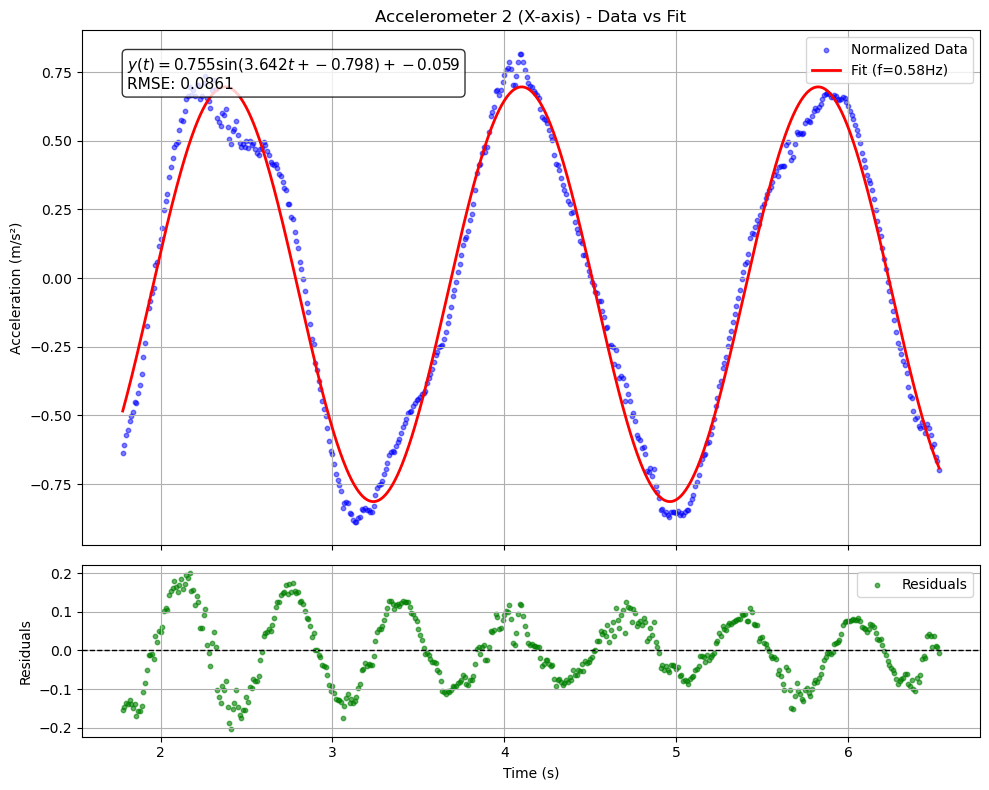

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def sine_function(t, A, omega, phi, offset):
    """
    Sinusoidal function with horizontal shift (phase phi) and vertical offset.
    y = A * sin(omega * t + phi) + offset
    """
    return A * np.sin(omega * t + phi) + offset

def process_and_fit(filename):
    # 1. Load the data
    df = pd.read_csv(filename)
    
    # Identify columns:
    t_exp = df['Time (s)'].values
    acc2_x = df['Ax (m/s²).1'].values
    
    # 2. Normalize (Center around zero)
    acc2_x_norm = acc2_x - np.mean(acc2_x)
    
    # 3. Fit to sinusoidal function
    guess_amp = 0.755
    guess_freq = 0.58 
    guess_omega = 2 * np.pi * guess_freq
    guess_phase = 0
    guess_offset = 0
    
    p0 = [guess_amp, guess_omega, guess_phase, guess_offset]
    
    try:
        popt, pcov = curve_fit(sine_function, t_exp, acc2_x_norm, p0=p0, maxfev=10000)
        
        # Extract parameters
        A_fit, omega_fit, phi_fit, offset_fit = popt
        
        # Calculate Frequency and Period
        frequency = abs(omega_fit) / (2 * np.pi)
        period = 1.0 / frequency
        
        y_model = sine_function(t_exp, *popt)
        residuals = acc2_x_norm - y_model
        
        # Calculate Root Mean Square Error (RMSE)
        rmse = np.sqrt(np.mean(residuals**2))

        print(f"--- Results for Accelerometer 2 (X-axis) ---")
        print(f"Frequency: {frequency:.4f} Hz")
        print(f"Period:    {period:.4f} s")
        print(f"RMSE:      {rmse:.4f} m/s²")
        
        # 4. Plotting
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, 
                                       gridspec_kw={'height_ratios': [3, 1]})
        
        # --- Top Plot: Data vs Fit ---
        ax1.scatter(t_exp, acc2_x_norm, s=10, label='Normalized Data', color='blue', alpha=0.5)
        
        t_smooth = np.linspace(min(t_exp), max(t_exp), 1000)
        ax1.plot(t_smooth, sine_function(t_smooth, *popt), 'r-', linewidth=2, label=f'Fit (f={frequency:.2f}Hz)')
        
        # --- ADDED SECTION: Display Equation on Plot ---
        # Format the equation string
        equation_text = (
            f"$y(t) = {A_fit:.3f} \sin({omega_fit:.3f} t + {phi_fit:.3f}) + {offset_fit:.3f}$\n"
            f"RMSE: {rmse:.4f}"
        )
        
        # Place text in top-left corner (0.05, 0.95 relative to axes)
        ax1.text(0.05, 0.95, equation_text, transform=ax1.transAxes, fontsize=11,
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        # -----------------------------------------------

        ax1.set_ylabel('Acceleration (m/s²)')
        ax1.set_title('Accelerometer 2 (X-axis) - Data vs Fit')
        ax1.legend(loc='upper right')
        ax1.grid(True)
        
        # --- Bottom Plot: Residuals ---
        ax2.scatter(t_exp, residuals, s=10, color='green', alpha=0.6, label='Residuals')
        ax2.axhline(0, color='black', linestyle='--', linewidth=1) 
        
        ax2.set_ylabel('Residuals')
        ax2.set_xlabel('Time (s)')
        ax2.legend(loc='upper right')
        ax2.grid(True)

        plt.tight_layout()
        plt.show()
        
        return frequency, period, residuals
        
    except Exception as e:
        print(f"Fitting failed: {e}")
        return None, None, None

# Execute the function
freq, per, res = process_and_fit('DowelInPhasePart2.csv')

--- Results for Accelerometer 2 (X-axis) ---
Frequency: 0.5790 Hz
Period:    1.7271 s
RMSE:      0.0765 m/s²


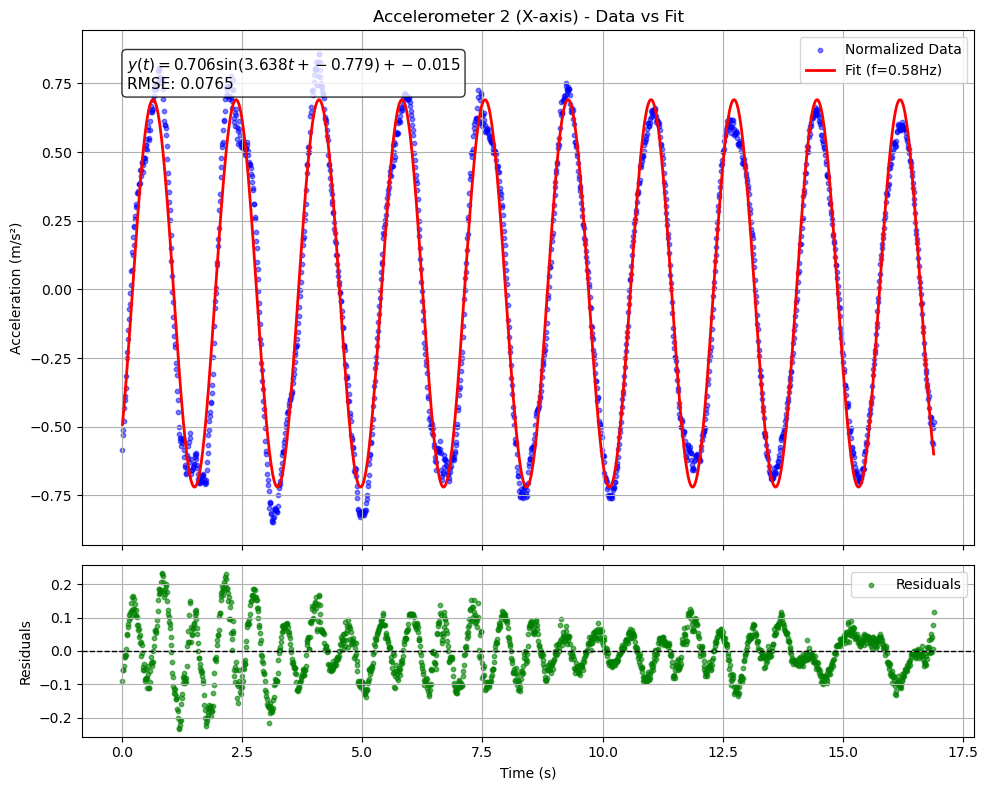

In [5]:
freq, per, _ = process_and_fit('DowelInPhasePart2Bigger.csv')

Optimizing time shift...
Optimal Time Shift found: 1.2000 seconds


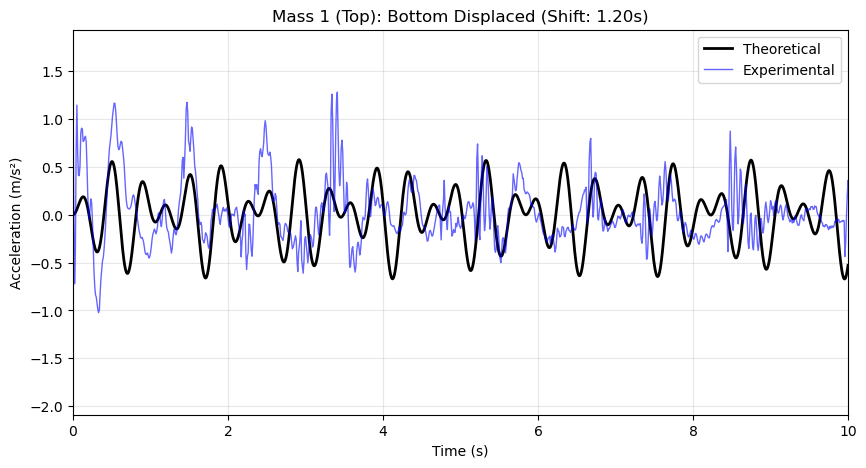

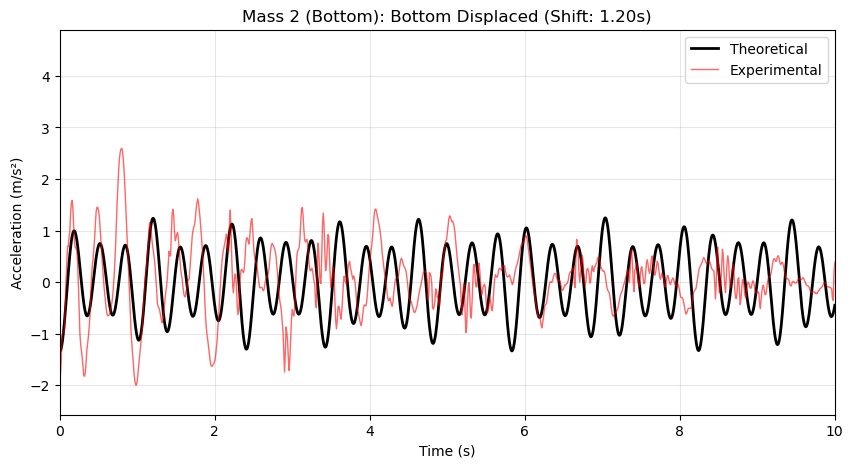

In [5]:
# ==========================================
# SIMULATION & ANALYSIS FOR BOTTOM DISPLACED
# ==========================================

# 1. Run Theory with NEW Initial Conditions
# Top Mass (Theta1) = 0 degrees
# Bottom Mass (Theta2) = 15 degrees
def run_simulation_bottom_displaced(duration=10, steps=2000):
    g = 9.81
    L = 0.40
    m = 0.200
    
    # Updated Initial Conditions
    theta1_0 = np.radians(0)   # Top mass at rest (vertical)
    theta2_0 = np.radians(15)  # Bottom mass displaced
    state0 = [theta1_0, 0, theta2_0, 0] 
    
    t = np.linspace(0, duration, steps)
    
    def deriv(state, t, g, L):
        theta1, omega1, theta2, omega2 = state
        # Linearized equations
        alpha1 = (g / L) * (theta2 - 2 * theta1)
        alpha2 = (2 * g / L) * (theta1 - theta2)
        return [omega1, alpha1, omega2, alpha2]

    sol = odeint(deriv, state0, t, args=(g, L))
    
    theta1, omega1 = sol[:, 0], sol[:, 1]
    theta2, omega2 = sol[:, 2], sol[:, 3]
    
    # Calculate Theoretical Accelerations
    alpha1 = (g / L) * (theta2 - 2 * theta1)
    alpha2 = (2 * g / L) * (theta1 - theta2)
    
    acc_y1_theory = L * (theta1 * alpha1 + omega1**2)
    acc_y_rel = L * (theta2 * alpha2 + omega2**2)
    acc_y2_theory = acc_y1_theory + acc_y_rel
    
    return t, acc_y1_theory, acc_y2_theory

# 2. Load and Process specific file
def load_bottom_displaced_data(filename):
    try:
        df = pd.read_csv(filename)
        
        # Column Mapping based on file inspection:
        # Index 0: Time
        # Index 2: Ay (Sensor 1) -> Mass 2 (Bottom)
        # Index 8: Ay (Sensor 2) -> Mass 1 (Top) [Corrected from 5]
        
        t_exp = df.iloc[:, 0].values
        acc1_exp = df.iloc[:, 8].values # Mass 1 (Top)
        acc2_exp = df.iloc[:, 2].values # Mass 2 (Bottom)
        
        # Normalize
        acc1_exp = acc1_exp - np.mean(acc1_exp)
        acc2_exp = acc2_exp - np.mean(acc2_exp)
        
        return t_exp, acc1_exp, acc2_exp
    except Exception as e:
        print(f"Error: {e}")
        return None, None, None

# --- MAIN EXECUTION ---

# Run Simulation
t_theory, y1_theory, y2_theory = run_simulation_bottom_displaced(duration=10)

# Load Data
filename = 'dowelBottomDisplaced.csv'
t_exp, y1_exp, y2_exp = load_bottom_displaced_data(filename)

if t_exp is not None:
    # Optimize Shift 
    # Expanded search bounds to ensure we find the start
    print("Optimizing time shift...")
    best_shift = find_best_shift(t_theory, y1_theory, t_exp, y1_exp, search_bounds=(0.0, 3.0))
    print(f"Optimal Time Shift found: {best_shift:.4f} seconds")

    t_exp_shifted = t_exp - best_shift

    # Plotting
    # Graph 1: Mass 1 (Top)
    plt.figure(figsize=(10, 5))
    plt.plot(t_theory, y1_theory, 'k-', linewidth=2, label='Theoretical')
    plt.plot(t_exp_shifted, y1_exp, 'b-', alpha=0.6, linewidth=1, label='Experimental')
    plt.title(f"Mass 1 (Top): Bottom Displaced (Shift: {best_shift:.2f}s)")
    plt.xlabel("Time (s)")
    plt.ylabel("Acceleration (m/s²)")
    plt.xlim(0, 10)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Graph 2: Mass 2 (Bottom)
    plt.figure(figsize=(10, 5))
    plt.plot(t_theory, y2_theory, 'k-', linewidth=2, label='Theoretical')
    plt.plot(t_exp_shifted, y2_exp, 'r-', alpha=0.6, linewidth=1, label='Experimental')
    plt.title(f"Mass 2 (Bottom): Bottom Displaced (Shift: {best_shift:.2f}s)")
    plt.xlabel("Time (s)")
    plt.ylabel("Acceleration (m/s²)")
    plt.xlim(0, 10)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

Optimizing time shift...
Optimal Time Shift found: 0.7620 seconds


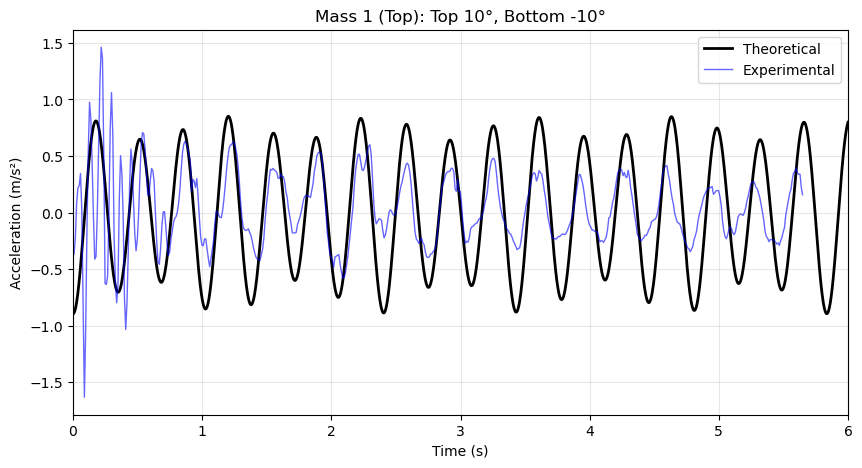

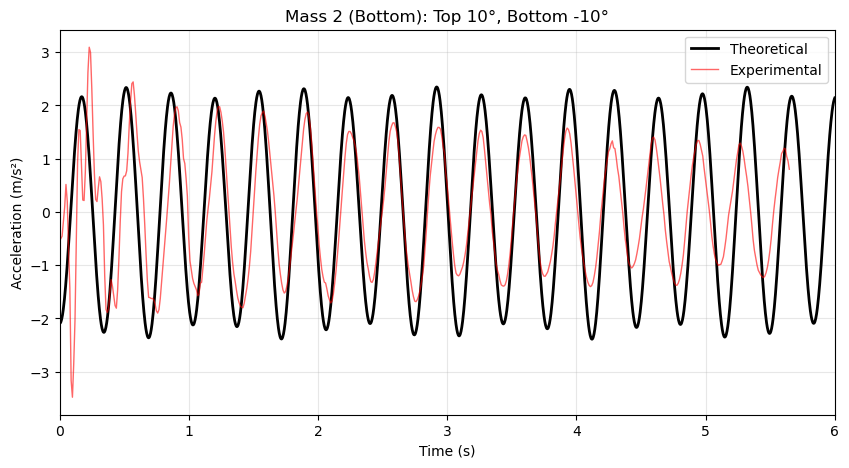

In [7]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar

# ==========================================
# SIMULATION & ANALYSIS (Shortened Duration)
# Top 10°, Bottom -10°
# ==========================================

# 1. Define the Data Loading Function
def load_top10_bottom_neg10_data(filename):
    try:
        df = pd.read_csv(filename)
        
        # Column Mapping:
        # Index 0: Time
        # Index 2: Ay (Sensor 1) -> Mass 2 (Bottom)
        # Index 8: Ay (Sensor 2) -> Mass 1 (Top)
        
        t_exp = df.iloc[:, 0].values
        acc1_exp = df.iloc[:, 8].values # Mass 1 (Top)
        acc2_exp = df.iloc[:, 2].values # Mass 2 (Bottom)
        
        # Normalize
        acc1_exp = acc1_exp - np.mean(acc1_exp)
        acc2_exp = acc2_exp - np.mean(acc2_exp)
        
        return t_exp, acc1_exp, acc2_exp
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None, None

# 2. Define the Simulation Function
def run_simulation_short(duration=6.0, steps=2000):
    g = 9.81
    L = 0.40
    
    # Initial Conditions: Top 10, Bottom -10
    theta1_0 = np.radians(10)
    theta2_0 = np.radians(-10)
    state0 = [theta1_0, 0, theta2_0, 0] 
    
    t = np.linspace(0, duration, steps)
    
    def deriv(state, t, g, L):
        theta1, omega1, theta2, omega2 = state
        # Linearized equations
        alpha1 = (g / L) * (theta2 - 2 * theta1)
        alpha2 = (2 * g / L) * (theta1 - theta2)
        return [omega1, alpha1, omega2, alpha2]

    sol = odeint(deriv, state0, t, args=(g, L))
    
    theta1, omega1 = sol[:, 0], sol[:, 1]
    theta2, omega2 = sol[:, 2], sol[:, 3]
    
    # Calculate Theoretical Accelerations
    alpha1 = (g / L) * (theta2 - 2 * theta1)
    alpha2 = (2 * g / L) * (theta1 - theta2)
    
    acc_y1_theory = L * (theta1 * alpha1 + omega1**2)
    acc_y_rel = L * (theta2 * alpha2 + omega2**2)
    acc_y2_theory = acc_y1_theory + acc_y_rel
    
    return t, acc_y1_theory, acc_y2_theory

# 3. Helper Function for Time Shift
def find_best_shift(t_theory, y_theory, t_exp, y_exp, search_bounds=(0.5, 1.5)):
    theory_interp = interp1d(t_theory, y_theory, kind='cubic', fill_value="extrapolate")
    
    def error_func(dt):
        t_shifted = t_exp - dt
        # Filter to overlapping region
        mask = (t_shifted >= t_theory.min()) & (t_shifted <= t_theory.max())
        if np.sum(mask) < 10: return float('inf')
        
        y_exp_segment = y_exp[mask]
        t_segment = t_shifted[mask]
        y_theory_interp = theory_interp(t_segment)
        return np.mean((y_exp_segment - y_theory_interp)**2)

    res = minimize_scalar(error_func, bounds=search_bounds, method='bounded')
    return res.x

# --- MAIN EXECUTION ---

# 1. Load Data
filename = 'toptendegreesBottomNegativeTenDegrees (1).csv'
t_exp, y1_exp, y2_exp = load_top10_bottom_neg10_data(filename)

if t_exp is not None:
    # 2. Determine Duration (Use 6.0s as requested)
    max_time = 6.0 
    
    # Run Simulation
    t_theory, y1_theory, y2_theory = run_simulation_short(duration=max_time)

    # 3. Optimize Shift 
    print("Optimizing time shift...")
    # Adjust search bounds if necessary based on where the data starts
    best_shift = find_best_shift(t_theory, y1_theory, t_exp, y1_exp, search_bounds=(0.0, 2.0))
    print(f"Optimal Time Shift found: {best_shift:.4f} seconds")

    t_exp_shifted = t_exp - best_shift

    # 4. Plotting
    # Graph 1: Mass 1 (Top)
    plt.figure(figsize=(10, 5))
    plt.plot(t_theory, y1_theory, 'k-', linewidth=2, label='Theoretical')
    plt.plot(t_exp_shifted, y1_exp, 'b-', alpha=0.6, linewidth=1, label='Experimental')
    plt.title(f"Mass 1 (Top): Top 10°, Bottom -10°")
    plt.xlabel("Time (s)")
    plt.ylabel("Acceleration (m/s²)")
    plt.xlim(0, max_time)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Graph 2: Mass 2 (Bottom)
    plt.figure(figsize=(10, 5))
    plt.plot(t_theory, y2_theory, 'k-', linewidth=2, label='Theoretical')
    plt.plot(t_exp_shifted, y2_exp, 'r-', alpha=0.6, linewidth=1, label='Experimental')
    plt.title(f"Mass 2 (Bottom): Top 10°, Bottom -10°")
    plt.xlabel("Time (s)")
    plt.ylabel("Acceleration (m/s²)")
    plt.xlim(0, max_time)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("Error: Could not load data file.")

Time Shift applied: 0.7717 s
Damping Factor used: 0.25


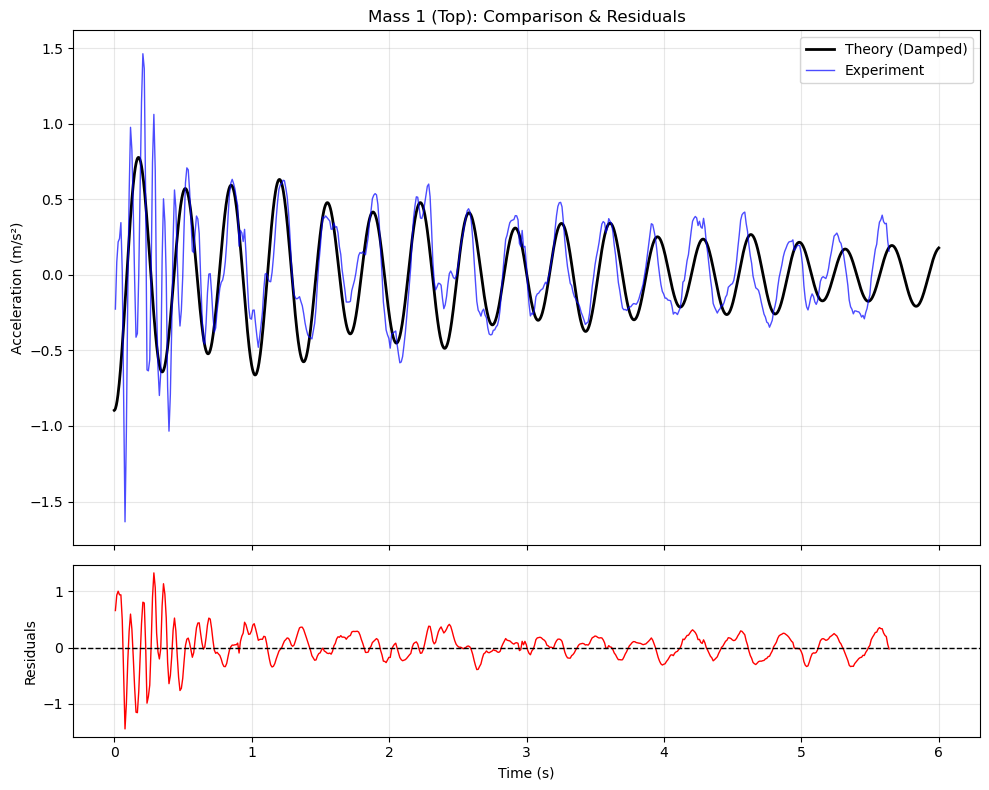

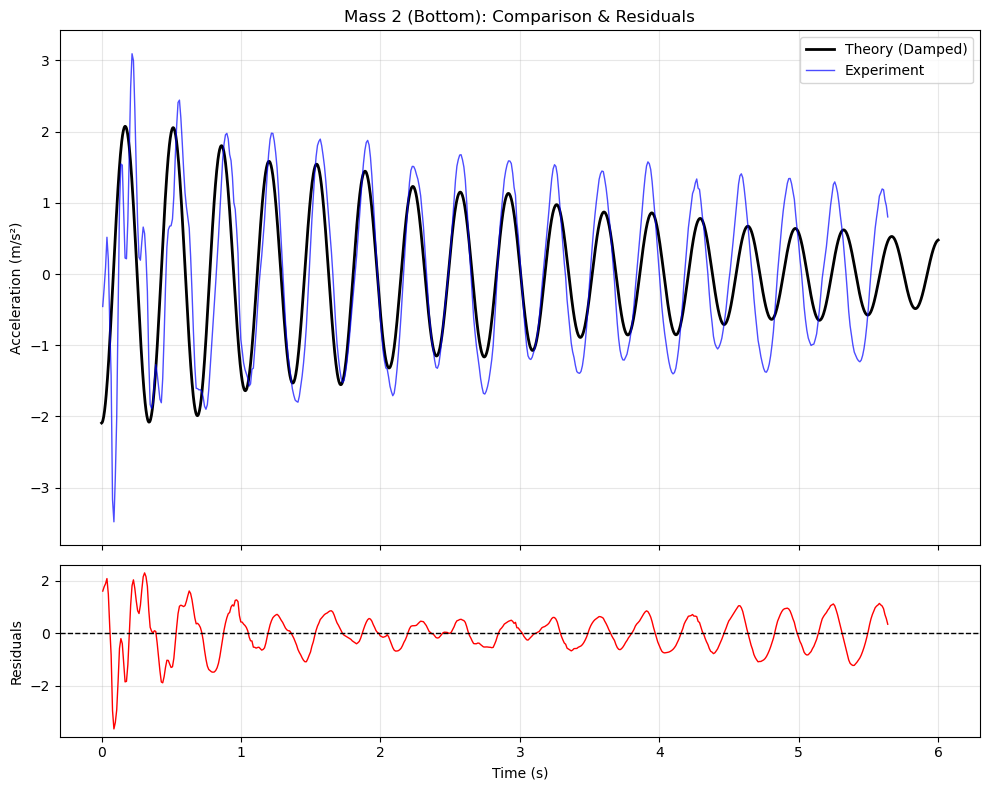

In [8]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar

# ==========================================
# 1. SIMULATION WITH DAMPING
# ==========================================
def run_simulation_damped(duration=6.0, steps=2000, damping=0.1):
    g = 9.81
    L = 0.40
    
    # Initial Conditions: Top 10, Bottom -10
    theta1_0 = np.radians(10)
    theta2_0 = np.radians(-10)
    state0 = [theta1_0, 0, theta2_0, 0] 
    
    t = np.linspace(0, duration, steps)
    
    def deriv(state, t, g, L, c):
        theta1, omega1, theta2, omega2 = state
        
        # Standard Coupled Equations
        alpha1 = (g / L) * (theta2 - 2 * theta1)
        alpha2 = (2 * g / L) * (theta1 - theta2)
        
        # Add Damping (Friction proportional to velocity)
        # c is the damping coefficient
        alpha1 -= c * omega1
        alpha2 -= c * omega2
        
        return [omega1, alpha1, omega2, alpha2]

    # Pass damping 'c' to the solver
    sol = odeint(deriv, state0, t, args=(g, L, damping))
    
    theta1, omega1 = sol[:, 0], sol[:, 1]
    theta2, omega2 = sol[:, 2], sol[:, 3]
    
    # Recalculate Alphas for Acceleration (including damping effect!)
    alpha1 = (g / L) * (theta2 - 2 * theta1) - damping * omega1
    alpha2 = (2 * g / L) * (theta1 - theta2) - damping * omega2
    
    acc_y1_theory = L * (theta1 * alpha1 + omega1**2)
    acc_y_rel = L * (theta2 * alpha2 + omega2**2)
    acc_y2_theory = acc_y1_theory + acc_y_rel
    
    return t, acc_y1_theory, acc_y2_theory

# ==========================================
# 2. DATA PROCESSING
# ==========================================
def load_data(filename):
    try:
        df = pd.read_csv(filename)
        # Index 2: Mass 2 (Bottom), Index 8: Mass 1 (Top)
        t = df.iloc[:, 0].values
        a1 = df.iloc[:, 8].values - np.mean(df.iloc[:, 8].values)
        a2 = df.iloc[:, 2].values - np.mean(df.iloc[:, 2].values)
        return t, a1, a2
    except:
        return None, None, None

def get_best_shift(t_theo, y_theo, t_exp, y_exp):
    f = interp1d(t_theo, y_theo, kind='cubic', fill_value="extrapolate")
    def err(dt):
        t_s = t_exp - dt
        mask = (t_s >= t_theo.min()) & (t_s <= t_theo.max())
        if np.sum(mask) < 10: return 1e6
        return np.mean((y_exp[mask] - f(t_s[mask]))**2)
    res = minimize_scalar(err, bounds=(0, 2), method='bounded')
    return res.x

# ==========================================
# 3. PLOTTING WITH RESIDUALS
# ==========================================
def plot_with_residuals(t_theo, y_theo, t_exp, y_exp, shift, title):
    # Interpolate Theory to Experimental Timestamps for Residual Calculation
    interp_func = interp1d(t_theo, y_theo, kind='cubic', fill_value="extrapolate")
    
    # Shift experimental time
    t_shifted = t_exp - shift
    
    # Filter to Valid Range (Overlap only)
    mask = (t_shifted >= 0) & (t_shifted <= 6.0)
    t_valid = t_shifted[mask]
    y_exp_valid = y_exp[mask]
    
    # Calculate Residuals (Exp - Theory)
    y_theo_at_exp_times = interp_func(t_valid)
    residuals = y_exp_valid - y_theo_at_exp_times
    
    # Create Plot (2 Rows)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
    
    # Top Plot: Comparison
    ax1.plot(t_theo, y_theo, 'k-', lw=2, label='Theory (Damped)')
    ax1.plot(t_valid, y_exp_valid, 'b-', lw=1, alpha=0.7, label='Experiment')
    ax1.set_title(title)
    ax1.set_ylabel('Acceleration (m/s²)')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # Bottom Plot: Residuals
    ax2.plot(t_valid, residuals, 'r-', lw=1)
    ax2.axhline(0, color='k', linestyle='--', lw=1)
    ax2.set_ylabel('Residuals')
    ax2.set_xlabel('Time (s)')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ==========================================
# MAIN EXECUTION
# ==========================================

# 1. Settings
DAMPING_FACTOR = 0.25  # <--- Adjust this if decay is too fast/slow
filename = 'toptendegreesBottomNegativeTenDegrees (1).csv'

# 2. Run
t_theo, y1_theo, y2_theo = run_simulation_damped(duration=6.0, damping=DAMPING_FACTOR)
t_exp, y1_exp, y2_exp = load_data(filename)

if t_exp is not None:
    # Find shift based on Mass 1
    shift = get_best_shift(t_theo, y1_theo, t_exp, y1_exp)
    print(f"Time Shift applied: {shift:.4f} s")
    print(f"Damping Factor used: {DAMPING_FACTOR}")

    # Plot Mass 1
    plot_with_residuals(t_theo, y1_theo, t_exp, y1_exp, shift, 
                        "Mass 1 (Top): Comparison & Residuals")
    
    # Plot Mass 2
    plot_with_residuals(t_theo, y2_theo, t_exp, y2_exp, shift, 
                        "Mass 2 (Bottom): Comparison & Residuals")

Optimizing Damping Factor... (this may take a few seconds)
Optimal Damping Factor Found: 0.23672


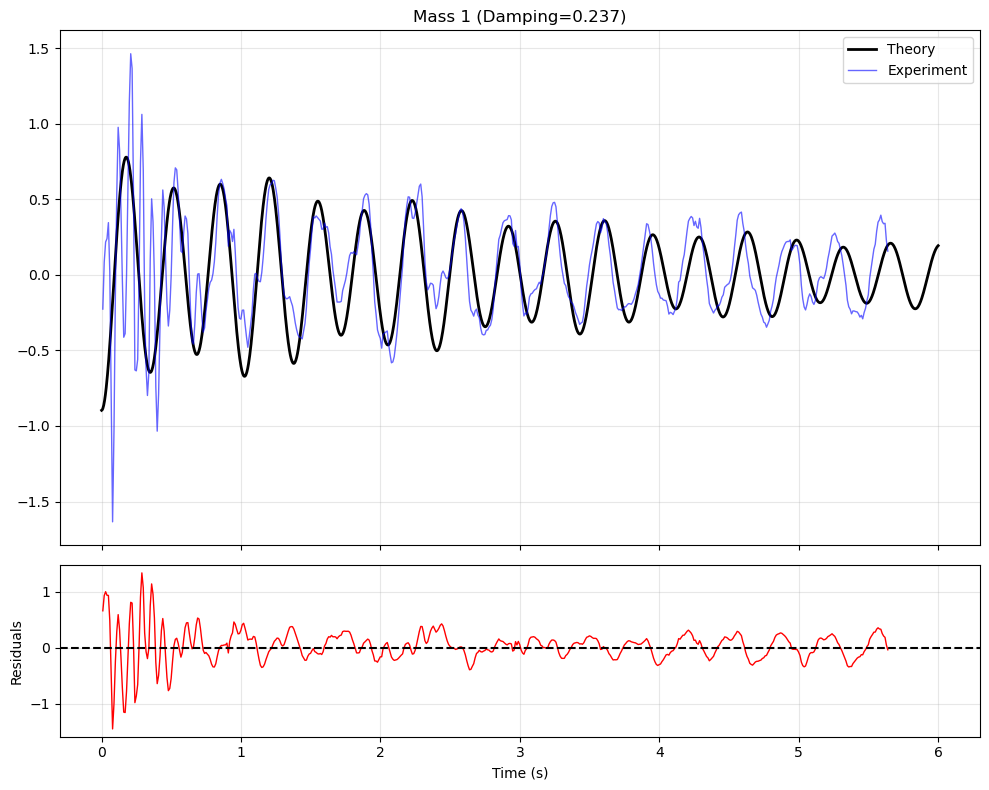

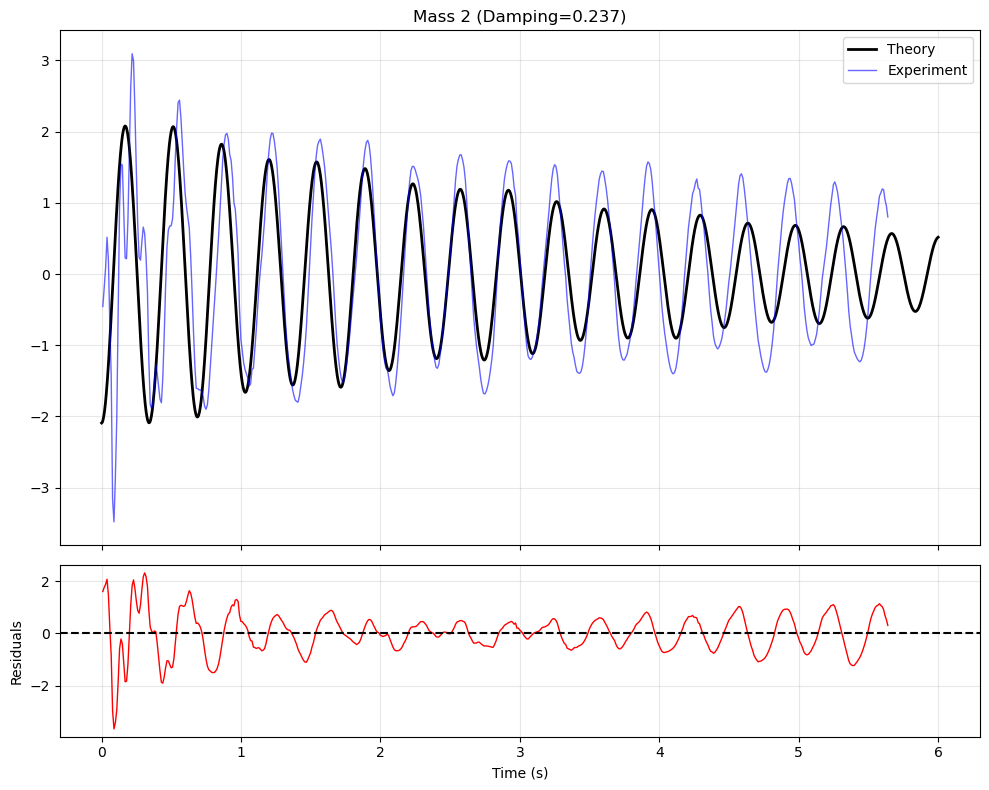

In [10]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar

# ==========================================
# 1. CORE SIMULATION
# ==========================================
def run_simulation_damped(damping, duration=6.0, steps=2000):
    g = 9.81
    L = 0.40
    
    # Initial Conditions: Top 10, Bottom -10
    theta1_0 = np.radians(10)
    theta2_0 = np.radians(-10)
    state0 = [theta1_0, 0, theta2_0, 0] 
    
    t = np.linspace(0, duration, steps)
    
    def deriv(state, t, g, L, c):
        theta1, omega1, theta2, omega2 = state
        
        # Standard Coupled Equations
        alpha1 = (g / L) * (theta2 - 2 * theta1)
        alpha2 = (2 * g / L) * (theta1 - theta2)
        
        # Add Damping (Friction proportional to velocity)
        alpha1 -= c * omega1
        alpha2 -= c * omega2
        
        return [omega1, alpha1, omega2, alpha2]

    sol = odeint(deriv, state0, t, args=(g, L, damping))
    
    theta1, omega1 = sol[:, 0], sol[:, 1]
    theta2, omega2 = sol[:, 2], sol[:, 3]
    
    # Recalculate Alphas (including damping!)
    alpha1 = (g / L) * (theta2 - 2 * theta1) - damping * omega1
    alpha2 = (2 * g / L) * (theta1 - theta2) - damping * omega2
    
    acc_y1_theory = L * (theta1 * alpha1 + omega1**2)
    acc_y_rel = L * (theta2 * alpha2 + omega2**2)
    acc_y2_theory = acc_y1_theory + acc_y_rel
    
    return t, acc_y1_theory, acc_y2_theory

# ==========================================
# 2. OPTIMIZATION FUNCTIONS
# ==========================================
def calculate_total_error(damping, t_exp, y1_exp, y2_exp):
    """
    Runs sim with 'damping', aligns time, and calculates Sum of Squared Residuals.
    """
    # 1. Run Sim
    t_theo, y1_theo, y2_theo = run_simulation_damped(damping)
    
    # 2. Find optimal time shift for THIS damping value
    # We create a quick interpolator to align them
    f1 = interp1d(t_theo, y1_theo, kind='cubic', fill_value="extrapolate")
    
    def time_shift_error(dt):
        t_s = t_exp - dt
        mask = (t_s >= 0) & (t_s <= 6.0)
        if np.sum(mask) < 50: return 1e9 # Penalty for no overlap
        # Check error on Mass 1 (Top mass usually cleaner signal)
        return np.sum((y1_exp[mask] - f1(t_s[mask]))**2)
    
    res_t = minimize_scalar(time_shift_error, bounds=(0, 2), method='bounded')
    best_shift = res_t.x
    
    # 3. Calculate Total Residual Error (Mass 1 + Mass 2)
    t_shifted = t_exp - best_shift
    mask = (t_shifted >= 0) & (t_shifted <= 6.0)
    
    # Interpolators
    f2 = interp1d(t_theo, y2_theo, kind='cubic', fill_value="extrapolate")
    
    err1 = np.sum((y1_exp[mask] - f1(t_shifted[mask]))**2)
    err2 = np.sum((y2_exp[mask] - f2(t_shifted[mask]))**2)
    
    return err1 + err2

# ==========================================
# 3. PLOTTING & LOADING
# ==========================================
def load_data(filename):
    try:
        df = pd.read_csv(filename)
        t = df.iloc[:, 0].values
        a1 = df.iloc[:, 8].values - np.mean(df.iloc[:, 8].values)
        a2 = df.iloc[:, 2].values - np.mean(df.iloc[:, 2].values)
        return t, a1, a2
    except Exception as e:
        print("Error loading:", e)
        return None, None, None

def plot_final(t_theo, y_theo, t_exp, y_exp, shift, title):
    f = interp1d(t_theo, y_theo, kind='cubic', fill_value="extrapolate")
    t_shifted = t_exp - shift
    mask = (t_shifted >= 0) & (t_shifted <= 6.0)
    
    residuals = y_exp[mask] - f(t_shifted[mask])
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
    
    ax1.plot(t_theo, y_theo, 'k-', lw=2, label='Theory')
    ax1.plot(t_shifted[mask], y_exp[mask], 'b-', lw=1, alpha=0.6, label='Experiment')
    ax1.set_title(title)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(t_shifted[mask], residuals, 'r-', lw=1)
    ax2.axhline(0, color='k', ls='--')
    ax2.set_ylabel('Residuals')
    ax2.set_xlabel('Time (s)')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ==========================================
# MAIN EXECUTION
# ==========================================
filename = 'toptendegreesBottomNegativeTenDegrees (1).csv'
t_exp, y1_exp, y2_exp = load_data(filename)

if t_exp is not None:
    print("Optimizing Damping Factor... (this may take a few seconds)")
    
    # We minimize the error function we defined above
    # Bounds: Search for damping between 0.0 (none) and 1.0 (heavy)
    res_d = minimize_scalar(lambda d: calculate_total_error(d, t_exp, y1_exp, y2_exp), 
                            bounds=(0.0, 1.0), method='bounded')
    
    best_damping = res_d.x
    print(f"Optimal Damping Factor Found: {best_damping:.5f}")
    
    # Run Final Sim with Best Damping
    t_theo, y1_theo, y2_theo = run_simulation_damped(best_damping)
    
    # Find Final Best Shift
    f1 = interp1d(t_theo, y1_theo, kind='cubic', fill_value="extrapolate")
    def get_shift(dt):
        t_s = t_exp - dt
        mask = (t_s >= 0) & (t_s <= 6.0)
        if np.sum(mask) < 10: return 1e9
        return np.sum((y1_exp[mask] - f1(t_s[mask]))**2)
        
    res_t = minimize_scalar(get_shift, bounds=(0, 2), method='bounded')
    best_shift = res_t.x
    
    # Plot
    plot_final(t_theo, y1_theo, t_exp, y1_exp, best_shift, f"Mass 1 (Damping={best_damping:.3f})")
    plot_final(t_theo, y2_theo, t_exp, y2_exp, best_shift, f"Mass 2 (Damping={best_damping:.3f})")